In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

import time
import numpy as np
import os
from tqdm import  tqdm

In [3]:
N_INPUTS = 2
N_CLASSES = 2
HIDDEN_LAYER = '20'

# Default constants
LEARNING_RATE = 0.01
EPOCH = 1500
EVAL_FREQ = 10

dataset_size = 1000
TEST_SIZE = 0.2

BATCH_SIZE = 128

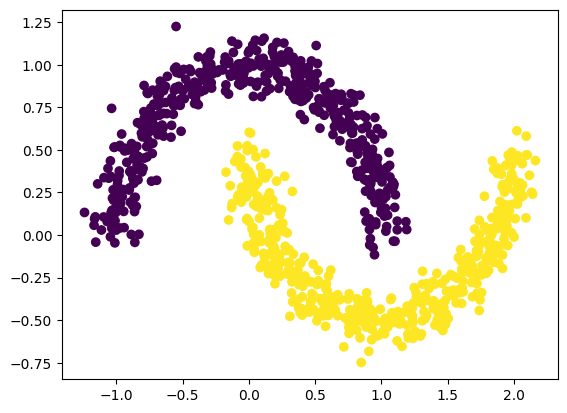

In [21]:
x, y = datasets.make_moons(n_samples=dataset_size, noise=0.08, shuffle=True, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE)

x_train_t = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test_t = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train_t = torch.from_numpy(y_train).type(torch.LongTensor)
y_test_t = torch.from_numpy(y_test).type(torch.LongTensor)

x_t = torch.from_numpy(x).type(torch.FloatTensor)
y_t = torch.from_numpy(y).type(torch.LongTensor)

train_dataset = TensorDataset(x_train_t, y_train_t)
test_dataset = TensorDataset(x_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

plt.scatter(x[:,0], x[:,1], c=y)

In [16]:
class MLP(nn.Module):

    def __init__(self, n_inputs, n_hidden, n_classes):
        """
        Initializes multi-layer perceptron object.    
        Args:
            n_inputs: number of inputs (i.e., dimension of an input vector).
            n_hidden: list of integers, where each integer is the number of units in each linear layer
            n_classes: number of classes of the classification problem (i.e., output dimension of the network)
        """
        super(MLP, self).__init__()
        self.input_layers = nn.Sequential()
        self.hidden_layers = nn.Sequential()
        self.output_layers = nn.Sequential()
        for index in range(len(n_hidden)):
            if index == 0:
                self.input_layers.add_module("input_layer",
                                             nn.Linear(in_features=n_inputs, out_features=int(n_hidden[index]),
                                                       bias=True))
                self.input_layers.add_module("input_relu",
                                             nn.ReLU())
            if index == len(n_hidden) - 1:
                self.output_layers.add_module("output_layer",
                                              nn.Linear(in_features=int(n_hidden[index]), out_features=n_classes,
                                                        bias=True))
            else:
                self.hidden_layers.add_module("hidden_layer" + str(index),
                                              nn.Linear(in_features=int(n_hidden[index]),
                                                        out_features=int(n_hidden[index + 1]), bias=True))
                self.hidden_layers.add_module("hidden_relu" + str(index),
                                              nn.ReLU())
                
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.001)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Predict network output from input by passing it through several layers.
        Args:
            x: input to the network
        Returns:
            out: output of the network
        """
        x = self.input_layers(x)
        x = self.hidden_layers(x)
        x = self.output_layers(x)
        return x


In [5]:
def accuracy(predictions, targets):
    """
    Computes the prediction accuracy, i.e., the average of correct predictions
    of the network.
    Args:
        predictions: 2D float array of size [number_of_data_samples, n_classes]
        labels: 2D int array of size [number_of_data_samples, n_classes] with one-hot encoding of ground-truth labels
    Returns:
        accuracy: scalar float, the accuracy of predictions.
    """
    total = predictions.shape[0]
    predictions = np.where(predictions > 0.5, 1, 0)
    acc_cnt = np.sum(predictions * targets)
    return acc_cnt / total

In [6]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []

In [13]:
def train(optimizer, learning_rate, max_epochs, eval_freq, save_para):
    """
    Performs training and evaluation of MLP model.
    NOTE: You should the model on the whole test set each eval_freq iterations.
    """
    # YOUR TRAINING CODE GOES HERE
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    
    print("start training MLP...")
    print(device)
    
    # 储存学习到的参数
    opt_save_path = "optimizer" + optimizer + '.pth'
    writer = SummaryWriter('./logs/' + optimizer + '/lr=' + str(learning_rate))
    
    hidden_layer = HIDDEN_LAYER.split(",")
    model = MLP(n_inputs=N_INPUTS, n_hidden=hidden_layer, n_classes=N_CLASSES)
    model.to(device)
    
    cost = nn.CrossEntropyLoss()
    
    if optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == 'ADAM':
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'BGD':
      optimizer = torch.optim.BGD(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(max_epochs)):
        
        model.train()
        
        train_acc_avg = 0.
        train_loss_avg = 0.
        
        for idx, (input, target) in enumerate(train_loader):
            
            input, target = input.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(input)
            loss = cost(output, target)    
            loss.backward()
            optimizer.step()
            
            # print("LOSS", loss.item())
            
            train_loss_avg += loss.item()
            
            _, id = torch.max(output.data, 1)
            train_acc_avg += torch.sum(id == target.data)/target.shape[0]
            
            
        if epoch % eval_freq == 0:
            
            test_acc_avg = 0.
            test_loss_avg = 0.
            
            with torch.no_grad():
                for idx, (input, target) in enumerate(test_loader):
                    
                    input, target = input.to(device), target.to(device)
                    
                    output = model(input)
                    
                    loss = cost(output, target)
                    
                    # print("TEST LOSS", loss.item())
                    
                    _, id = torch.max(output.data, 1)
                    
                    test_loss_avg += loss.item()
                    test_acc_avg += torch.sum(id == target.data)/target.shape[0]
                
                epoch_list.append(epoch)
                
                train_loss_avg = train_loss_avg/len(train_loader)
                loss_train_list.append(train_loss_avg)
                
                test_loss_avg = test_loss_avg/len(test_loader)
                loss_test_list.append(test_loss_avg)
                
                train_acc_avg = train_acc_avg/len(train_loader)
                acc_train_list.append(train_acc_avg)
                
                test_acc_avg = test_acc_avg/len(test_loader)
                acc_test_list.append(test_acc_avg)
                
                print('TRAIN epoch: %d, loss : %lf, ACC: %lf' %(epoch, train_loss_avg, train_acc_avg))
                print('TEST epoch: %d, loss : %lf, ACC: %lf' %(epoch, test_loss_avg, test_acc_avg))
                    
    return model
        

In [8]:
model = train(optimizer='SGD', learning_rate=0.01, max_epochs=1500, eval_freq=10, save_para=False)

start training MLP...
cuda:0


  0%|          | 1/1500 [00:00<13:54,  1.80it/s]

TRAIN epoch: 0, loss : 0.693152, ACC: 0.531250
TEST epoch: 0, loss : 0.693149, ACC: 0.498264


  1%|          | 11/1500 [00:03<08:39,  2.86it/s]

TRAIN epoch: 10, loss : 0.693141, ACC: 0.505580
TEST epoch: 10, loss : 0.693113, ACC: 0.507378


  1%|▏         | 21/1500 [00:06<08:25,  2.93it/s]

TRAIN epoch: 20, loss : 0.693101, ACC: 0.508929
TEST epoch: 20, loss : 0.693210, ACC: 0.492188


  2%|▏         | 31/1500 [00:09<08:16,  2.96it/s]

TRAIN epoch: 30, loss : 0.693055, ACC: 0.512277
TEST epoch: 30, loss : 0.693426, ACC: 0.476997


  3%|▎         | 41/1500 [00:12<08:17,  2.93it/s]

TRAIN epoch: 40, loss : 0.693115, ACC: 0.505580
TEST epoch: 40, loss : 0.693205, ACC: 0.495226


  3%|▎         | 51/1500 [00:15<08:19,  2.90it/s]

TRAIN epoch: 50, loss : 0.692978, ACC: 0.515625
TEST epoch: 50, loss : 0.693306, ACC: 0.489149


  4%|▍         | 61/1500 [00:18<08:11,  2.93it/s]

TRAIN epoch: 60, loss : 0.692942, ACC: 0.518973
TEST epoch: 60, loss : 0.693286, ACC: 0.489149


  5%|▍         | 71/1500 [00:20<08:05,  2.94it/s]

TRAIN epoch: 70, loss : 0.693072, ACC: 0.505580
TEST epoch: 70, loss : 0.693218, ACC: 0.486111


  5%|▌         | 81/1500 [00:23<07:52,  3.00it/s]

TRAIN epoch: 80, loss : 0.693062, ACC: 0.502232
TEST epoch: 80, loss : 0.693222, ACC: 0.486111


  6%|▌         | 91/1500 [00:26<07:54,  2.97it/s]

TRAIN epoch: 90, loss : 0.693029, ACC: 0.502232
TEST epoch: 90, loss : 0.693112, ACC: 0.492188


  7%|▋         | 101/1500 [00:29<07:51,  2.97it/s]

TRAIN epoch: 100, loss : 0.692983, ACC: 0.498884
TEST epoch: 100, loss : 0.693042, ACC: 0.492188


  7%|▋         | 111/1500 [00:32<07:59,  2.90it/s]

TRAIN epoch: 110, loss : 0.692809, ACC: 0.505580
TEST epoch: 110, loss : 0.692788, ACC: 0.504340


  8%|▊         | 121/1500 [00:35<07:58,  2.88it/s]

TRAIN epoch: 120, loss : 0.692484, ACC: 0.522321
TEST epoch: 120, loss : 0.692786, ACC: 0.489149


  9%|▊         | 131/1500 [00:38<07:47,  2.93it/s]

TRAIN epoch: 130, loss : 0.692516, ACC: 0.492188
TEST epoch: 130, loss : 0.692524, ACC: 0.483073


  9%|▉         | 141/1500 [00:41<07:43,  2.93it/s]

TRAIN epoch: 140, loss : 0.692163, ACC: 0.485491
TEST epoch: 140, loss : 0.691951, ACC: 0.489149


 10%|█         | 151/1500 [00:44<07:44,  2.91it/s]

TRAIN epoch: 150, loss : 0.691199, ACC: 0.518973
TEST epoch: 150, loss : 0.691195, ACC: 0.504340


 11%|█         | 161/1500 [00:47<07:41,  2.90it/s]

TRAIN epoch: 160, loss : 0.690392, ACC: 0.492188
TEST epoch: 160, loss : 0.690352, ACC: 0.483073


 11%|█▏        | 171/1500 [00:50<07:36,  2.91it/s]

TRAIN epoch: 170, loss : 0.688803, ACC: 0.549107
TEST epoch: 170, loss : 0.688734, ACC: 0.588542


 12%|█▏        | 181/1500 [00:52<07:27,  2.95it/s]

TRAIN epoch: 180, loss : 0.686376, ACC: 0.793527
TEST epoch: 180, loss : 0.685941, ACC: 0.785590


 13%|█▎        | 191/1500 [00:55<07:27,  2.92it/s]

TRAIN epoch: 190, loss : 0.682750, ACC: 0.813616
TEST epoch: 190, loss : 0.681820, ACC: 0.791233


 13%|█▎        | 201/1500 [00:58<07:20,  2.95it/s]

TRAIN epoch: 200, loss : 0.676492, ACC: 0.838170
TEST epoch: 200, loss : 0.675526, ACC: 0.802517


 14%|█▍        | 211/1500 [01:01<07:15,  2.96it/s]

TRAIN epoch: 210, loss : 0.668812, ACC: 0.793527
TEST epoch: 210, loss : 0.667316, ACC: 0.790365


 15%|█▍        | 221/1500 [01:04<07:25,  2.87it/s]

TRAIN epoch: 220, loss : 0.656728, ACC: 0.815848
TEST epoch: 220, loss : 0.654150, ACC: 0.815104


 15%|█▌        | 231/1500 [01:07<07:10,  2.95it/s]

TRAIN epoch: 230, loss : 0.639019, ACC: 0.803571
TEST epoch: 230, loss : 0.634329, ACC: 0.828993


 16%|█▌        | 241/1500 [01:10<07:04,  2.96it/s]

TRAIN epoch: 240, loss : 0.617322, ACC: 0.804688
TEST epoch: 240, loss : 0.613385, ACC: 0.813802


 17%|█▋        | 251/1500 [01:13<07:07,  2.92it/s]

TRAIN epoch: 250, loss : 0.586824, ACC: 0.819196
TEST epoch: 250, loss : 0.581042, ACC: 0.829861


 17%|█▋        | 261/1500 [01:16<07:03,  2.93it/s]

TRAIN epoch: 260, loss : 0.550665, ACC: 0.813616
TEST epoch: 260, loss : 0.548786, ACC: 0.817708


 18%|█▊        | 271/1500 [01:19<07:04,  2.90it/s]

TRAIN epoch: 270, loss : 0.520332, ACC: 0.804688
TEST epoch: 270, loss : 0.514937, ACC: 0.818576


 19%|█▊        | 281/1500 [01:21<07:01,  2.89it/s]

TRAIN epoch: 280, loss : 0.487849, ACC: 0.797991
TEST epoch: 280, loss : 0.463870, ACC: 0.840712


 19%|█▉        | 291/1500 [01:24<06:58,  2.89it/s]

TRAIN epoch: 290, loss : 0.450983, ACC: 0.809152
TEST epoch: 290, loss : 0.429545, ACC: 0.848524


 20%|██        | 301/1500 [01:27<06:48,  2.94it/s]

TRAIN epoch: 300, loss : 0.409234, ACC: 0.828125
TEST epoch: 300, loss : 0.401444, ACC: 0.842448


 21%|██        | 311/1500 [01:30<06:46,  2.93it/s]

TRAIN epoch: 310, loss : 0.397854, ACC: 0.823661
TEST epoch: 310, loss : 0.370347, ACC: 0.855469


 21%|██▏       | 321/1500 [01:33<06:44,  2.91it/s]

TRAIN epoch: 320, loss : 0.371462, ACC: 0.831473
TEST epoch: 320, loss : 0.348573, ACC: 0.862413


 22%|██▏       | 331/1500 [01:36<06:43,  2.90it/s]

TRAIN epoch: 330, loss : 0.351010, ACC: 0.831473
TEST epoch: 330, loss : 0.342276, ACC: 0.854167


 23%|██▎       | 341/1500 [01:39<06:34,  2.94it/s]

TRAIN epoch: 340, loss : 0.340583, ACC: 0.839286
TEST epoch: 340, loss : 0.321384, ACC: 0.857205


 23%|██▎       | 351/1500 [01:42<06:31,  2.94it/s]

TRAIN epoch: 350, loss : 0.321119, ACC: 0.850446
TEST epoch: 350, loss : 0.302628, ACC: 0.863281


 24%|██▍       | 361/1500 [01:45<06:34,  2.89it/s]

TRAIN epoch: 360, loss : 0.319430, ACC: 0.837054
TEST epoch: 360, loss : 0.292412, ACC: 0.866319


 25%|██▍       | 371/1500 [01:48<06:29,  2.90it/s]

TRAIN epoch: 370, loss : 0.313339, ACC: 0.832589
TEST epoch: 370, loss : 0.283031, ACC: 0.871094


 25%|██▌       | 381/1500 [01:51<06:25,  2.90it/s]

TRAIN epoch: 380, loss : 0.299892, ACC: 0.850446
TEST epoch: 380, loss : 0.268620, ACC: 0.877170


 26%|██▌       | 391/1500 [01:53<06:19,  2.92it/s]

TRAIN epoch: 390, loss : 0.295951, ACC: 0.856027
TEST epoch: 390, loss : 0.277721, ACC: 0.865017


 27%|██▋       | 401/1500 [01:56<06:14,  2.94it/s]

TRAIN epoch: 400, loss : 0.288476, ACC: 0.857143
TEST epoch: 400, loss : 0.273863, ACC: 0.868924


 27%|██▋       | 411/1500 [01:59<06:12,  2.92it/s]

TRAIN epoch: 410, loss : 0.282623, ACC: 0.861607
TEST epoch: 410, loss : 0.250703, ACC: 0.887153


 28%|██▊       | 421/1500 [02:02<06:09,  2.92it/s]

TRAIN epoch: 420, loss : 0.287155, ACC: 0.860491
TEST epoch: 420, loss : 0.247237, ACC: 0.888021


 29%|██▊       | 431/1500 [02:05<06:09,  2.89it/s]

TRAIN epoch: 430, loss : 0.268619, ACC: 0.870536
TEST epoch: 430, loss : 0.253333, ACC: 0.878906


 29%|██▉       | 441/1500 [02:08<06:01,  2.93it/s]

TRAIN epoch: 440, loss : 0.266112, ACC: 0.873884
TEST epoch: 440, loss : 0.249159, ACC: 0.888889


 30%|███       | 451/1500 [02:11<05:57,  2.93it/s]

TRAIN epoch: 450, loss : 0.263730, ACC: 0.871652
TEST epoch: 450, loss : 0.245711, ACC: 0.885851


 31%|███       | 461/1500 [02:14<05:53,  2.94it/s]

TRAIN epoch: 460, loss : 0.267175, ACC: 0.866071
TEST epoch: 460, loss : 0.229607, ACC: 0.898003


 31%|███▏      | 471/1500 [02:17<05:55,  2.89it/s]

TRAIN epoch: 470, loss : 0.268364, ACC: 0.877232
TEST epoch: 470, loss : 0.233274, ACC: 0.898872


 32%|███▏      | 481/1500 [02:20<05:49,  2.92it/s]

TRAIN epoch: 480, loss : 0.270244, ACC: 0.867188
TEST epoch: 480, loss : 0.240255, ACC: 0.895833


 33%|███▎      | 491/1500 [02:22<05:48,  2.89it/s]

TRAIN epoch: 490, loss : 0.260015, ACC: 0.875000
TEST epoch: 490, loss : 0.243524, ACC: 0.886719


 33%|███▎      | 501/1500 [02:25<05:45,  2.89it/s]

TRAIN epoch: 500, loss : 0.253627, ACC: 0.886161
TEST epoch: 500, loss : 0.248460, ACC: 0.886719


 34%|███▍      | 511/1500 [02:28<05:41,  2.90it/s]

TRAIN epoch: 510, loss : 0.257804, ACC: 0.876116
TEST epoch: 510, loss : 0.228542, ACC: 0.901910


 35%|███▍      | 521/1500 [02:31<05:38,  2.89it/s]

TRAIN epoch: 520, loss : 0.259079, ACC: 0.876116
TEST epoch: 520, loss : 0.239674, ACC: 0.886719


 35%|███▌      | 531/1500 [02:34<05:44,  2.81it/s]

TRAIN epoch: 530, loss : 0.260623, ACC: 0.872768
TEST epoch: 530, loss : 0.246631, ACC: 0.876736


 36%|███▌      | 541/1500 [02:37<05:43,  2.79it/s]

TRAIN epoch: 540, loss : 0.256317, ACC: 0.879464
TEST epoch: 540, loss : 0.235619, ACC: 0.882812


 37%|███▋      | 551/1500 [02:40<05:34,  2.84it/s]

TRAIN epoch: 550, loss : 0.260613, ACC: 0.876116
TEST epoch: 550, loss : 0.237943, ACC: 0.883681


 37%|███▋      | 561/1500 [02:43<05:30,  2.84it/s]

TRAIN epoch: 560, loss : 0.250136, ACC: 0.881696
TEST epoch: 560, loss : 0.243006, ACC: 0.873698


 38%|███▊      | 571/1500 [02:46<05:28,  2.83it/s]

TRAIN epoch: 570, loss : 0.249246, ACC: 0.875000
TEST epoch: 570, loss : 0.234726, ACC: 0.889757


 39%|███▊      | 581/1500 [02:49<05:30,  2.78it/s]

TRAIN epoch: 580, loss : 0.264737, ACC: 0.867188
TEST epoch: 580, loss : 0.241200, ACC: 0.882812


 39%|███▉      | 591/1500 [02:52<05:22,  2.82it/s]

TRAIN epoch: 590, loss : 0.250102, ACC: 0.880580
TEST epoch: 590, loss : 0.244097, ACC: 0.883681


 40%|████      | 601/1500 [02:55<05:12,  2.88it/s]

TRAIN epoch: 600, loss : 0.259196, ACC: 0.876116
TEST epoch: 600, loss : 0.250677, ACC: 0.883681


 41%|████      | 611/1500 [02:58<05:11,  2.85it/s]

TRAIN epoch: 610, loss : 0.263437, ACC: 0.871652
TEST epoch: 610, loss : 0.235569, ACC: 0.896701


 41%|████▏     | 621/1500 [03:01<05:07,  2.86it/s]

TRAIN epoch: 620, loss : 0.242257, ACC: 0.886161
TEST epoch: 620, loss : 0.240496, ACC: 0.883681


 42%|████▏     | 631/1500 [03:04<05:11,  2.79it/s]

TRAIN epoch: 630, loss : 0.252341, ACC: 0.880580
TEST epoch: 630, loss : 0.230328, ACC: 0.884983


 43%|████▎     | 641/1500 [03:07<04:55,  2.91it/s]

TRAIN epoch: 640, loss : 0.247377, ACC: 0.880580
TEST epoch: 640, loss : 0.235187, ACC: 0.888889


 43%|████▎     | 651/1500 [03:10<04:53,  2.89it/s]

TRAIN epoch: 650, loss : 0.254701, ACC: 0.876116
TEST epoch: 650, loss : 0.235535, ACC: 0.879774


 44%|████▍     | 661/1500 [03:13<04:51,  2.87it/s]

TRAIN epoch: 660, loss : 0.270537, ACC: 0.867188
TEST epoch: 660, loss : 0.223961, ACC: 0.888889


 45%|████▍     | 671/1500 [03:16<04:45,  2.90it/s]

TRAIN epoch: 670, loss : 0.261397, ACC: 0.877232
TEST epoch: 670, loss : 0.228654, ACC: 0.888889


 45%|████▌     | 681/1500 [03:19<04:44,  2.88it/s]

TRAIN epoch: 680, loss : 0.256780, ACC: 0.870536
TEST epoch: 680, loss : 0.248409, ACC: 0.873698


 46%|████▌     | 691/1500 [03:22<04:38,  2.91it/s]

TRAIN epoch: 690, loss : 0.246491, ACC: 0.887277
TEST epoch: 690, loss : 0.230615, ACC: 0.888889


 47%|████▋     | 701/1500 [03:25<04:41,  2.83it/s]

TRAIN epoch: 700, loss : 0.250025, ACC: 0.876116
TEST epoch: 700, loss : 0.247997, ACC: 0.866753


 47%|████▋     | 711/1500 [03:28<04:29,  2.92it/s]

TRAIN epoch: 710, loss : 0.247404, ACC: 0.880580
TEST epoch: 710, loss : 0.223607, ACC: 0.891927


 48%|████▊     | 721/1500 [03:31<04:27,  2.92it/s]

TRAIN epoch: 720, loss : 0.245505, ACC: 0.880580
TEST epoch: 720, loss : 0.243139, ACC: 0.870660


 49%|████▊     | 731/1500 [03:34<04:23,  2.92it/s]

TRAIN epoch: 730, loss : 0.258710, ACC: 0.870536
TEST epoch: 730, loss : 0.242091, ACC: 0.876736


 49%|████▉     | 741/1500 [03:37<04:21,  2.91it/s]

TRAIN epoch: 740, loss : 0.256130, ACC: 0.873884
TEST epoch: 740, loss : 0.238664, ACC: 0.882812


 50%|█████     | 751/1500 [03:40<04:19,  2.89it/s]

TRAIN epoch: 750, loss : 0.253575, ACC: 0.877232
TEST epoch: 750, loss : 0.247052, ACC: 0.873698


 51%|█████     | 761/1500 [03:43<04:13,  2.92it/s]

TRAIN epoch: 760, loss : 0.269403, ACC: 0.863839
TEST epoch: 760, loss : 0.235186, ACC: 0.876736


 51%|█████▏    | 771/1500 [03:45<04:11,  2.90it/s]

TRAIN epoch: 770, loss : 0.270354, ACC: 0.863839
TEST epoch: 770, loss : 0.233277, ACC: 0.882812


 52%|█████▏    | 781/1500 [03:48<04:06,  2.92it/s]

TRAIN epoch: 780, loss : 0.256471, ACC: 0.877232
TEST epoch: 780, loss : 0.246153, ACC: 0.883681


 53%|█████▎    | 791/1500 [03:51<04:05,  2.88it/s]

TRAIN epoch: 790, loss : 0.259546, ACC: 0.877232
TEST epoch: 790, loss : 0.240835, ACC: 0.879774


 53%|█████▎    | 801/1500 [03:54<04:02,  2.88it/s]

TRAIN epoch: 800, loss : 0.250599, ACC: 0.881696
TEST epoch: 800, loss : 0.220146, ACC: 0.898003


 54%|█████▍    | 811/1500 [03:57<03:55,  2.93it/s]

TRAIN epoch: 810, loss : 0.257641, ACC: 0.873884
TEST epoch: 810, loss : 0.232967, ACC: 0.882812


 55%|█████▍    | 821/1500 [04:00<03:52,  2.92it/s]

TRAIN epoch: 820, loss : 0.266361, ACC: 0.877232
TEST epoch: 820, loss : 0.213094, ACC: 0.898003


 55%|█████▌    | 831/1500 [04:03<03:55,  2.84it/s]

TRAIN epoch: 830, loss : 0.259038, ACC: 0.872768
TEST epoch: 830, loss : 0.229222, ACC: 0.882812


 56%|█████▌    | 841/1500 [04:06<03:43,  2.94it/s]

TRAIN epoch: 840, loss : 0.255650, ACC: 0.869420
TEST epoch: 840, loss : 0.239377, ACC: 0.882812


 57%|█████▋    | 851/1500 [04:09<03:48,  2.84it/s]

TRAIN epoch: 850, loss : 0.266096, ACC: 0.867188
TEST epoch: 850, loss : 0.226340, ACC: 0.894965


 57%|█████▋    | 861/1500 [04:12<03:36,  2.95it/s]

TRAIN epoch: 860, loss : 0.252305, ACC: 0.877232
TEST epoch: 860, loss : 0.236608, ACC: 0.885851


 58%|█████▊    | 871/1500 [04:15<03:37,  2.90it/s]

TRAIN epoch: 870, loss : 0.260283, ACC: 0.871652
TEST epoch: 870, loss : 0.227936, ACC: 0.882812


 59%|█████▊    | 881/1500 [04:18<03:31,  2.92it/s]

TRAIN epoch: 880, loss : 0.242814, ACC: 0.886161
TEST epoch: 880, loss : 0.218209, ACC: 0.894965


 59%|█████▉    | 891/1500 [04:21<03:27,  2.93it/s]

TRAIN epoch: 890, loss : 0.263578, ACC: 0.872768
TEST epoch: 890, loss : 0.230137, ACC: 0.885851


 60%|██████    | 901/1500 [04:23<03:25,  2.91it/s]

TRAIN epoch: 900, loss : 0.243453, ACC: 0.879464
TEST epoch: 900, loss : 0.225624, ACC: 0.885851


 61%|██████    | 911/1500 [04:26<03:25,  2.86it/s]

TRAIN epoch: 910, loss : 0.258253, ACC: 0.870536
TEST epoch: 910, loss : 0.240045, ACC: 0.882812


 61%|██████▏   | 921/1500 [04:29<03:18,  2.92it/s]

TRAIN epoch: 920, loss : 0.244447, ACC: 0.881696
TEST epoch: 920, loss : 0.239218, ACC: 0.882812


 62%|██████▏   | 931/1500 [04:32<03:14,  2.93it/s]

TRAIN epoch: 930, loss : 0.252090, ACC: 0.880580
TEST epoch: 930, loss : 0.222326, ACC: 0.895833


 63%|██████▎   | 941/1500 [04:35<03:09,  2.95it/s]

TRAIN epoch: 940, loss : 0.250866, ACC: 0.876116
TEST epoch: 940, loss : 0.246228, ACC: 0.882812


 63%|██████▎   | 951/1500 [04:38<03:09,  2.90it/s]

TRAIN epoch: 950, loss : 0.249246, ACC: 0.877232
TEST epoch: 950, loss : 0.236752, ACC: 0.882812


 64%|██████▍   | 961/1500 [04:41<03:04,  2.91it/s]

TRAIN epoch: 960, loss : 0.239119, ACC: 0.883929
TEST epoch: 960, loss : 0.252250, ACC: 0.873698


 65%|██████▍   | 971/1500 [04:44<03:05,  2.85it/s]

TRAIN epoch: 970, loss : 0.246896, ACC: 0.891741
TEST epoch: 970, loss : 0.225167, ACC: 0.895833


 65%|██████▌   | 981/1500 [04:47<02:57,  2.92it/s]

TRAIN epoch: 980, loss : 0.242932, ACC: 0.880580
TEST epoch: 980, loss : 0.223108, ACC: 0.888889


 66%|██████▌   | 991/1500 [04:50<02:56,  2.88it/s]

TRAIN epoch: 990, loss : 0.240163, ACC: 0.878348
TEST epoch: 990, loss : 0.222266, ACC: 0.898003


 67%|██████▋   | 1001/1500 [04:53<02:57,  2.82it/s]

TRAIN epoch: 1000, loss : 0.248403, ACC: 0.880580
TEST epoch: 1000, loss : 0.227740, ACC: 0.891927


 67%|██████▋   | 1011/1500 [04:56<02:50,  2.87it/s]

TRAIN epoch: 1010, loss : 0.238598, ACC: 0.885045
TEST epoch: 1010, loss : 0.242003, ACC: 0.876736


 68%|██████▊   | 1021/1500 [04:59<02:45,  2.89it/s]

TRAIN epoch: 1020, loss : 0.253301, ACC: 0.876116
TEST epoch: 1020, loss : 0.236666, ACC: 0.882812


 69%|██████▊   | 1031/1500 [05:02<02:45,  2.84it/s]

TRAIN epoch: 1030, loss : 0.265930, ACC: 0.870536
TEST epoch: 1030, loss : 0.234645, ACC: 0.892795


 69%|██████▉   | 1041/1500 [05:05<02:41,  2.84it/s]

TRAIN epoch: 1040, loss : 0.265240, ACC: 0.876116
TEST epoch: 1040, loss : 0.255091, ACC: 0.868490


 70%|███████   | 1051/1500 [05:08<02:36,  2.88it/s]

TRAIN epoch: 1050, loss : 0.270325, ACC: 0.858259
TEST epoch: 1050, loss : 0.217634, ACC: 0.898872


 71%|███████   | 1061/1500 [05:11<02:30,  2.91it/s]

TRAIN epoch: 1060, loss : 0.260966, ACC: 0.868304
TEST epoch: 1060, loss : 0.237207, ACC: 0.886719


 71%|███████▏  | 1071/1500 [05:14<02:29,  2.87it/s]

TRAIN epoch: 1070, loss : 0.260228, ACC: 0.876116
TEST epoch: 1070, loss : 0.227396, ACC: 0.891927


 72%|███████▏  | 1081/1500 [05:16<02:25,  2.89it/s]

TRAIN epoch: 1080, loss : 0.244757, ACC: 0.885045
TEST epoch: 1080, loss : 0.223992, ACC: 0.888889


 73%|███████▎  | 1091/1500 [05:19<02:20,  2.91it/s]

TRAIN epoch: 1090, loss : 0.241932, ACC: 0.882813
TEST epoch: 1090, loss : 0.213429, ACC: 0.898003


 73%|███████▎  | 1101/1500 [05:22<02:18,  2.88it/s]

TRAIN epoch: 1100, loss : 0.255355, ACC: 0.877232
TEST epoch: 1100, loss : 0.231115, ACC: 0.885851


 74%|███████▍  | 1111/1500 [05:25<02:13,  2.92it/s]

TRAIN epoch: 1110, loss : 0.252900, ACC: 0.872768
TEST epoch: 1110, loss : 0.235860, ACC: 0.882812


 75%|███████▍  | 1121/1500 [05:28<02:09,  2.92it/s]

TRAIN epoch: 1120, loss : 0.257205, ACC: 0.871652
TEST epoch: 1120, loss : 0.224785, ACC: 0.892795


 75%|███████▌  | 1131/1500 [05:31<02:06,  2.91it/s]

TRAIN epoch: 1130, loss : 0.243818, ACC: 0.878348
TEST epoch: 1130, loss : 0.234821, ACC: 0.888889


 76%|███████▌  | 1141/1500 [05:34<02:04,  2.90it/s]

TRAIN epoch: 1140, loss : 0.253069, ACC: 0.872768
TEST epoch: 1140, loss : 0.224417, ACC: 0.888889


 77%|███████▋  | 1151/1500 [05:37<01:59,  2.92it/s]

TRAIN epoch: 1150, loss : 0.249049, ACC: 0.882813
TEST epoch: 1150, loss : 0.229437, ACC: 0.892795


 77%|███████▋  | 1161/1500 [05:40<01:59,  2.83it/s]

TRAIN epoch: 1160, loss : 0.239989, ACC: 0.886161
TEST epoch: 1160, loss : 0.239583, ACC: 0.883681


 78%|███████▊  | 1171/1500 [05:43<01:52,  2.92it/s]

TRAIN epoch: 1170, loss : 0.243912, ACC: 0.873884
TEST epoch: 1170, loss : 0.240488, ACC: 0.876736


 79%|███████▊  | 1181/1500 [05:46<01:50,  2.88it/s]

TRAIN epoch: 1180, loss : 0.255514, ACC: 0.879464
TEST epoch: 1180, loss : 0.232247, ACC: 0.891927


 79%|███████▉  | 1191/1500 [05:49<01:46,  2.91it/s]

TRAIN epoch: 1190, loss : 0.248131, ACC: 0.878348
TEST epoch: 1190, loss : 0.214731, ACC: 0.901042


 80%|████████  | 1201/1500 [05:52<01:42,  2.92it/s]

TRAIN epoch: 1200, loss : 0.252240, ACC: 0.877232
TEST epoch: 1200, loss : 0.225580, ACC: 0.882812


 81%|████████  | 1211/1500 [05:55<01:43,  2.78it/s]

TRAIN epoch: 1210, loss : 0.249873, ACC: 0.879464
TEST epoch: 1210, loss : 0.224765, ACC: 0.891927


 81%|████████▏ | 1221/1500 [05:58<01:36,  2.88it/s]

TRAIN epoch: 1220, loss : 0.256320, ACC: 0.875000
TEST epoch: 1220, loss : 0.254287, ACC: 0.883681


 82%|████████▏ | 1231/1500 [06:01<01:32,  2.91it/s]

TRAIN epoch: 1230, loss : 0.263804, ACC: 0.866071
TEST epoch: 1230, loss : 0.244280, ACC: 0.889757


 83%|████████▎ | 1241/1500 [06:03<01:32,  2.81it/s]

TRAIN epoch: 1240, loss : 0.253998, ACC: 0.871652
TEST epoch: 1240, loss : 0.222767, ACC: 0.888889


 83%|████████▎ | 1251/1500 [06:06<01:26,  2.89it/s]

TRAIN epoch: 1250, loss : 0.259829, ACC: 0.875000
TEST epoch: 1250, loss : 0.210622, ACC: 0.898003


 84%|████████▍ | 1261/1500 [06:09<01:22,  2.90it/s]

TRAIN epoch: 1260, loss : 0.264856, ACC: 0.868304
TEST epoch: 1260, loss : 0.242386, ACC: 0.882812


 85%|████████▍ | 1271/1500 [06:12<01:18,  2.92it/s]

TRAIN epoch: 1270, loss : 0.267738, ACC: 0.870536
TEST epoch: 1270, loss : 0.222247, ACC: 0.898872


 85%|████████▌ | 1281/1500 [06:15<01:15,  2.92it/s]

TRAIN epoch: 1280, loss : 0.260250, ACC: 0.876116
TEST epoch: 1280, loss : 0.232425, ACC: 0.892795


 86%|████████▌ | 1291/1500 [06:19<01:40,  2.07it/s]

TRAIN epoch: 1290, loss : 0.243136, ACC: 0.887277
TEST epoch: 1290, loss : 0.226807, ACC: 0.891927


 87%|████████▋ | 1301/1500 [06:23<01:40,  1.98it/s]

TRAIN epoch: 1300, loss : 0.257969, ACC: 0.875000
TEST epoch: 1300, loss : 0.232852, ACC: 0.882812


 87%|████████▋ | 1311/1500 [06:28<01:35,  1.97it/s]

TRAIN epoch: 1310, loss : 0.240213, ACC: 0.883929
TEST epoch: 1310, loss : 0.233740, ACC: 0.886719


 88%|████████▊ | 1321/1500 [06:32<01:24,  2.11it/s]

TRAIN epoch: 1320, loss : 0.268537, ACC: 0.868304
TEST epoch: 1320, loss : 0.233758, ACC: 0.885851


 89%|████████▊ | 1331/1500 [06:36<01:25,  1.98it/s]

TRAIN epoch: 1330, loss : 0.266313, ACC: 0.864955
TEST epoch: 1330, loss : 0.224243, ACC: 0.885851


 89%|████████▉ | 1341/1500 [06:40<01:21,  1.95it/s]

TRAIN epoch: 1340, loss : 0.262392, ACC: 0.870536
TEST epoch: 1340, loss : 0.226488, ACC: 0.885851


 90%|█████████ | 1351/1500 [06:45<01:15,  1.98it/s]

TRAIN epoch: 1350, loss : 0.239528, ACC: 0.885045
TEST epoch: 1350, loss : 0.233188, ACC: 0.888889


 91%|█████████ | 1361/1500 [06:49<01:10,  1.97it/s]

TRAIN epoch: 1360, loss : 0.246215, ACC: 0.881696
TEST epoch: 1360, loss : 0.228513, ACC: 0.898872


 91%|█████████▏| 1371/1500 [06:53<01:05,  1.98it/s]

TRAIN epoch: 1370, loss : 0.251130, ACC: 0.877232
TEST epoch: 1370, loss : 0.240133, ACC: 0.883681


 92%|█████████▏| 1381/1500 [06:58<01:01,  1.95it/s]

TRAIN epoch: 1380, loss : 0.243712, ACC: 0.882813
TEST epoch: 1380, loss : 0.218138, ACC: 0.891927


 93%|█████████▎| 1391/1500 [07:02<00:55,  1.95it/s]

TRAIN epoch: 1390, loss : 0.262887, ACC: 0.877232
TEST epoch: 1390, loss : 0.245136, ACC: 0.879774


 93%|█████████▎| 1401/1500 [07:06<00:50,  1.97it/s]

TRAIN epoch: 1400, loss : 0.256788, ACC: 0.873884
TEST epoch: 1400, loss : 0.225992, ACC: 0.892795


 94%|█████████▍| 1411/1500 [07:11<00:45,  1.96it/s]

TRAIN epoch: 1410, loss : 0.242290, ACC: 0.888393
TEST epoch: 1410, loss : 0.236154, ACC: 0.885851


 95%|█████████▍| 1421/1500 [07:15<00:39,  1.98it/s]

TRAIN epoch: 1420, loss : 0.257280, ACC: 0.877232
TEST epoch: 1420, loss : 0.255904, ACC: 0.874566


 95%|█████████▌| 1431/1500 [07:19<00:34,  1.97it/s]

TRAIN epoch: 1430, loss : 0.257638, ACC: 0.875000
TEST epoch: 1430, loss : 0.218033, ACC: 0.888889


 96%|█████████▌| 1441/1500 [07:24<00:30,  1.96it/s]

TRAIN epoch: 1440, loss : 0.262826, ACC: 0.871652
TEST epoch: 1440, loss : 0.229720, ACC: 0.895833


 97%|█████████▋| 1451/1500 [07:28<00:24,  1.97it/s]

TRAIN epoch: 1450, loss : 0.249194, ACC: 0.879464
TEST epoch: 1450, loss : 0.226010, ACC: 0.885851


 97%|█████████▋| 1461/1500 [07:32<00:19,  1.96it/s]

TRAIN epoch: 1460, loss : 0.264485, ACC: 0.861607
TEST epoch: 1460, loss : 0.238261, ACC: 0.882812


 98%|█████████▊| 1471/1500 [07:37<00:15,  1.88it/s]

TRAIN epoch: 1470, loss : 0.255277, ACC: 0.872768
TEST epoch: 1470, loss : 0.249552, ACC: 0.870660


 99%|█████████▊| 1481/1500 [07:41<00:09,  1.97it/s]

TRAIN epoch: 1480, loss : 0.242319, ACC: 0.886161
TEST epoch: 1480, loss : 0.223642, ACC: 0.891927


 99%|█████████▉| 1491/1500 [07:44<00:03,  2.80it/s]

TRAIN epoch: 1490, loss : 0.254731, ACC: 0.872768
TEST epoch: 1490, loss : 0.224850, ACC: 0.888889


100%|██████████| 1500/1500 [07:47<00:00,  3.21it/s]


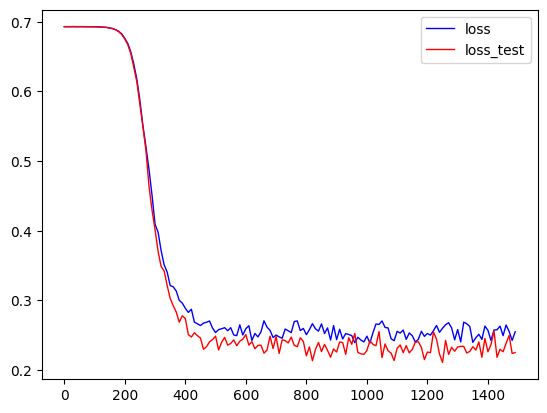

In [9]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

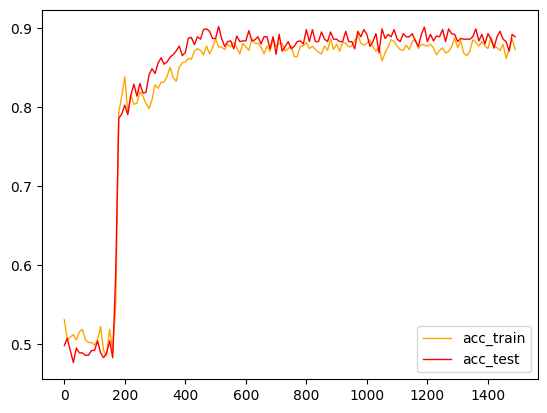

In [10]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()

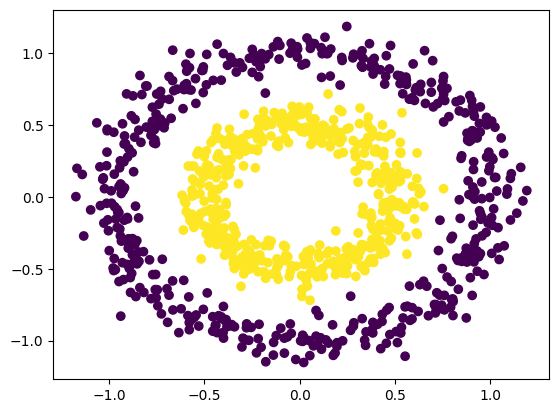

In [20]:
x, y = datasets.make_circles(n_samples=dataset_size, noise=0.08, factor=0.5, shuffle=True, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE)

x_train_t = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test_t = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train_t = torch.from_numpy(y_train).type(torch.LongTensor)
y_test_t = torch.from_numpy(y_test).type(torch.LongTensor)

x_t = torch.from_numpy(x).type(torch.FloatTensor)
y_t = torch.from_numpy(y).type(torch.LongTensor)

train_dataset = TensorDataset(x_train_t, y_train_t)
test_dataset = TensorDataset(x_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

plt.scatter(x[:,0], x[:,1], c=y)

In [21]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []

In [22]:
model = train(optimizer='SGD', learning_rate=0.01, max_epochs=5000, eval_freq=10, save_para=False)

start training MLP...
cuda:0


  0%|          | 1/5000 [00:00<45:40,  1.82it/s]

TRAIN epoch: 0, loss : 0.693166, ACC: 0.505580
TEST epoch: 0, loss : 0.693158, ACC: 0.491753


  0%|          | 11/5000 [00:03<30:29,  2.73it/s]

TRAIN epoch: 10, loss : 0.693029, ACC: 0.513393
TEST epoch: 10, loss : 0.693694, ACC: 0.455295


  0%|          | 21/5000 [00:06<29:49,  2.78it/s]

TRAIN epoch: 20, loss : 0.693135, ACC: 0.503348
TEST epoch: 20, loss : 0.693640, ACC: 0.467448


  1%|          | 31/5000 [00:09<30:32,  2.71it/s]

TRAIN epoch: 30, loss : 0.692796, ACC: 0.516741
TEST epoch: 30, loss : 0.694364, ACC: 0.461372


  1%|          | 41/5000 [00:12<29:14,  2.83it/s]

TRAIN epoch: 40, loss : 0.693160, ACC: 0.503348
TEST epoch: 40, loss : 0.693555, ACC: 0.488715


  1%|          | 51/5000 [00:15<28:53,  2.85it/s]

TRAIN epoch: 50, loss : 0.693301, ACC: 0.500000
TEST epoch: 50, loss : 0.694396, ACC: 0.461372


  1%|          | 61/5000 [00:18<30:15,  2.72it/s]

TRAIN epoch: 60, loss : 0.692953, ACC: 0.510045
TEST epoch: 60, loss : 0.694490, ACC: 0.464410


  1%|▏         | 71/5000 [00:21<30:04,  2.73it/s]

TRAIN epoch: 70, loss : 0.692962, ACC: 0.510045
TEST epoch: 70, loss : 0.694630, ACC: 0.455295


  2%|▏         | 81/5000 [00:24<28:56,  2.83it/s]

TRAIN epoch: 80, loss : 0.693496, ACC: 0.493304
TEST epoch: 80, loss : 0.694173, ACC: 0.467448


  2%|▏         | 91/5000 [00:27<29:52,  2.74it/s]

TRAIN epoch: 90, loss : 0.693251, ACC: 0.500000
TEST epoch: 90, loss : 0.694000, ACC: 0.467448


  2%|▏         | 101/5000 [00:30<28:46,  2.84it/s]

TRAIN epoch: 100, loss : 0.693064, ACC: 0.506696
TEST epoch: 100, loss : 0.693918, ACC: 0.479601


  2%|▏         | 111/5000 [00:33<28:56,  2.82it/s]

TRAIN epoch: 110, loss : 0.693362, ACC: 0.496652
TEST epoch: 110, loss : 0.694354, ACC: 0.458333


  2%|▏         | 121/5000 [00:36<28:43,  2.83it/s]

TRAIN epoch: 120, loss : 0.693157, ACC: 0.503348
TEST epoch: 120, loss : 0.694055, ACC: 0.467448


  3%|▎         | 131/5000 [00:39<28:36,  2.84it/s]

TRAIN epoch: 130, loss : 0.692785, ACC: 0.516741
TEST epoch: 130, loss : 0.694158, ACC: 0.470486


  3%|▎         | 141/5000 [00:42<28:38,  2.83it/s]

TRAIN epoch: 140, loss : 0.693077, ACC: 0.506696
TEST epoch: 140, loss : 0.693520, ACC: 0.491753


  3%|▎         | 151/5000 [00:45<29:57,  2.70it/s]

TRAIN epoch: 150, loss : 0.692675, ACC: 0.520089
TEST epoch: 150, loss : 0.694755, ACC: 0.452257


  3%|▎         | 161/5000 [00:49<28:39,  2.81it/s]

TRAIN epoch: 160, loss : 0.693109, ACC: 0.506696
TEST epoch: 160, loss : 0.694807, ACC: 0.452257


  3%|▎         | 171/5000 [00:51<28:35,  2.81it/s]

TRAIN epoch: 170, loss : 0.692659, ACC: 0.520089
TEST epoch: 170, loss : 0.694548, ACC: 0.461372


  4%|▎         | 181/5000 [00:55<29:15,  2.74it/s]

TRAIN epoch: 180, loss : 0.693079, ACC: 0.506696
TEST epoch: 180, loss : 0.694507, ACC: 0.467448


  4%|▍         | 191/5000 [00:58<28:39,  2.80it/s]

TRAIN epoch: 190, loss : 0.693289, ACC: 0.500000
TEST epoch: 190, loss : 0.693829, ACC: 0.482639


  4%|▍         | 201/5000 [01:01<28:12,  2.84it/s]

TRAIN epoch: 200, loss : 0.693485, ACC: 0.493304
TEST epoch: 200, loss : 0.693925, ACC: 0.476562


  4%|▍         | 211/5000 [01:04<28:20,  2.82it/s]

TRAIN epoch: 210, loss : 0.692485, ACC: 0.526786
TEST epoch: 210, loss : 0.693841, ACC: 0.482639


  4%|▍         | 221/5000 [01:07<28:21,  2.81it/s]

TRAIN epoch: 220, loss : 0.692971, ACC: 0.510045
TEST epoch: 220, loss : 0.694033, ACC: 0.473524


  5%|▍         | 231/5000 [01:10<28:09,  2.82it/s]

TRAIN epoch: 230, loss : 0.692961, ACC: 0.510045
TEST epoch: 230, loss : 0.694840, ACC: 0.458333


  5%|▍         | 241/5000 [01:13<28:04,  2.82it/s]

TRAIN epoch: 240, loss : 0.692949, ACC: 0.510045
TEST epoch: 240, loss : 0.694152, ACC: 0.476562


  5%|▌         | 251/5000 [01:16<28:19,  2.79it/s]

TRAIN epoch: 250, loss : 0.693479, ACC: 0.496652
TEST epoch: 250, loss : 0.693739, ACC: 0.488715


  5%|▌         | 261/5000 [01:19<28:10,  2.80it/s]

TRAIN epoch: 260, loss : 0.693260, ACC: 0.500000
TEST epoch: 260, loss : 0.694545, ACC: 0.452257


  5%|▌         | 271/5000 [01:22<28:28,  2.77it/s]

TRAIN epoch: 270, loss : 0.692980, ACC: 0.510045
TEST epoch: 270, loss : 0.694222, ACC: 0.461372


  6%|▌         | 281/5000 [01:25<28:07,  2.80it/s]

TRAIN epoch: 280, loss : 0.692778, ACC: 0.516741
TEST epoch: 280, loss : 0.693758, ACC: 0.482639


  6%|▌         | 291/5000 [01:28<28:51,  2.72it/s]

TRAIN epoch: 290, loss : 0.693079, ACC: 0.506696
TEST epoch: 290, loss : 0.694768, ACC: 0.461372


  6%|▌         | 301/5000 [01:31<28:12,  2.78it/s]

TRAIN epoch: 300, loss : 0.693563, ACC: 0.493304
TEST epoch: 300, loss : 0.694088, ACC: 0.476562


  6%|▌         | 311/5000 [01:34<27:35,  2.83it/s]

TRAIN epoch: 310, loss : 0.693179, ACC: 0.503348
TEST epoch: 310, loss : 0.693974, ACC: 0.479601


  6%|▋         | 321/5000 [01:37<27:48,  2.80it/s]

TRAIN epoch: 320, loss : 0.693269, ACC: 0.500000
TEST epoch: 320, loss : 0.693584, ACC: 0.488715


  7%|▋         | 331/5000 [01:40<27:20,  2.85it/s]

TRAIN epoch: 330, loss : 0.693432, ACC: 0.493304
TEST epoch: 330, loss : 0.693785, ACC: 0.476562


  7%|▋         | 341/5000 [01:43<27:28,  2.83it/s]

TRAIN epoch: 340, loss : 0.692980, ACC: 0.510045
TEST epoch: 340, loss : 0.693469, ACC: 0.491753


  7%|▋         | 351/5000 [01:46<28:52,  2.68it/s]

TRAIN epoch: 350, loss : 0.692459, ACC: 0.526786
TEST epoch: 350, loss : 0.694498, ACC: 0.464410


  7%|▋         | 361/5000 [01:49<27:21,  2.83it/s]

TRAIN epoch: 360, loss : 0.692821, ACC: 0.513393
TEST epoch: 360, loss : 0.694347, ACC: 0.470486


  7%|▋         | 371/5000 [01:52<27:25,  2.81it/s]

TRAIN epoch: 370, loss : 0.692840, ACC: 0.513393
TEST epoch: 370, loss : 0.693689, ACC: 0.488715


  8%|▊         | 381/5000 [01:55<27:19,  2.82it/s]

TRAIN epoch: 380, loss : 0.693182, ACC: 0.503348
TEST epoch: 380, loss : 0.693669, ACC: 0.488715


  8%|▊         | 391/5000 [01:58<27:23,  2.80it/s]

TRAIN epoch: 390, loss : 0.693176, ACC: 0.503348
TEST epoch: 390, loss : 0.693872, ACC: 0.482639


  8%|▊         | 401/5000 [02:01<27:46,  2.76it/s]

TRAIN epoch: 400, loss : 0.692761, ACC: 0.516741
TEST epoch: 400, loss : 0.694580, ACC: 0.458333


  8%|▊         | 411/5000 [02:04<27:26,  2.79it/s]

TRAIN epoch: 410, loss : 0.693352, ACC: 0.496652
TEST epoch: 410, loss : 0.694138, ACC: 0.467448


  8%|▊         | 421/5000 [02:07<28:02,  2.72it/s]

TRAIN epoch: 420, loss : 0.693598, ACC: 0.493304
TEST epoch: 420, loss : 0.694248, ACC: 0.473524


  9%|▊         | 431/5000 [02:10<27:06,  2.81it/s]

TRAIN epoch: 430, loss : 0.692947, ACC: 0.510045
TEST epoch: 430, loss : 0.694031, ACC: 0.476562


  9%|▉         | 441/5000 [02:13<27:38,  2.75it/s]

TRAIN epoch: 440, loss : 0.692522, ACC: 0.523438
TEST epoch: 440, loss : 0.694364, ACC: 0.467448


  9%|▉         | 451/5000 [02:16<26:32,  2.86it/s]

TRAIN epoch: 450, loss : 0.692931, ACC: 0.510045
TEST epoch: 450, loss : 0.693439, ACC: 0.494792


  9%|▉         | 461/5000 [02:20<26:41,  2.83it/s]

TRAIN epoch: 460, loss : 0.693162, ACC: 0.503348
TEST epoch: 460, loss : 0.693968, ACC: 0.479601


  9%|▉         | 471/5000 [02:23<30:03,  2.51it/s]

TRAIN epoch: 470, loss : 0.692722, ACC: 0.516741
TEST epoch: 470, loss : 0.694593, ACC: 0.464410


 10%|▉         | 481/5000 [02:26<26:49,  2.81it/s]

TRAIN epoch: 480, loss : 0.693047, ACC: 0.506696
TEST epoch: 480, loss : 0.693573, ACC: 0.491753


 10%|▉         | 491/5000 [02:29<26:46,  2.81it/s]

TRAIN epoch: 490, loss : 0.693327, ACC: 0.496652
TEST epoch: 490, loss : 0.693781, ACC: 0.479601


 10%|█         | 501/5000 [02:32<26:47,  2.80it/s]

TRAIN epoch: 500, loss : 0.693022, ACC: 0.506696
TEST epoch: 500, loss : 0.694239, ACC: 0.464410


 10%|█         | 511/5000 [02:35<26:23,  2.84it/s]

TRAIN epoch: 510, loss : 0.693219, ACC: 0.500000
TEST epoch: 510, loss : 0.694071, ACC: 0.467448


 10%|█         | 521/5000 [02:38<26:26,  2.82it/s]

TRAIN epoch: 520, loss : 0.693022, ACC: 0.506696
TEST epoch: 520, loss : 0.694308, ACC: 0.464410


 11%|█         | 531/5000 [02:41<26:14,  2.84it/s]

TRAIN epoch: 530, loss : 0.692918, ACC: 0.510045
TEST epoch: 530, loss : 0.694743, ACC: 0.455295


 11%|█         | 541/5000 [02:44<26:52,  2.76it/s]

TRAIN epoch: 540, loss : 0.693119, ACC: 0.503348
TEST epoch: 540, loss : 0.693847, ACC: 0.479601


 11%|█         | 551/5000 [02:47<26:29,  2.80it/s]

TRAIN epoch: 550, loss : 0.693188, ACC: 0.500000
TEST epoch: 550, loss : 0.694080, ACC: 0.464410


 11%|█         | 561/5000 [02:50<26:36,  2.78it/s]

TRAIN epoch: 560, loss : 0.693095, ACC: 0.503348
TEST epoch: 560, loss : 0.694108, ACC: 0.464410


 11%|█▏        | 571/5000 [02:53<26:43,  2.76it/s]

TRAIN epoch: 570, loss : 0.692775, ACC: 0.513393
TEST epoch: 570, loss : 0.693975, ACC: 0.479601


 12%|█▏        | 581/5000 [02:56<26:21,  2.79it/s]

TRAIN epoch: 580, loss : 0.692877, ACC: 0.510045
TEST epoch: 580, loss : 0.694195, ACC: 0.470486


 12%|█▏        | 591/5000 [02:59<25:55,  2.83it/s]

TRAIN epoch: 590, loss : 0.693224, ACC: 0.500000
TEST epoch: 590, loss : 0.694218, ACC: 0.470486


 12%|█▏        | 601/5000 [03:02<27:17,  2.69it/s]

TRAIN epoch: 600, loss : 0.692670, ACC: 0.516741
TEST epoch: 600, loss : 0.694186, ACC: 0.467448


 12%|█▏        | 611/5000 [03:05<26:46,  2.73it/s]

TRAIN epoch: 610, loss : 0.692648, ACC: 0.516741
TEST epoch: 610, loss : 0.693641, ACC: 0.485677


 12%|█▏        | 621/5000 [03:08<25:53,  2.82it/s]

TRAIN epoch: 620, loss : 0.692756, ACC: 0.513393
TEST epoch: 620, loss : 0.693799, ACC: 0.479601


 13%|█▎        | 631/5000 [03:11<25:32,  2.85it/s]

TRAIN epoch: 630, loss : 0.692965, ACC: 0.506696
TEST epoch: 630, loss : 0.693859, ACC: 0.476562


 13%|█▎        | 641/5000 [03:14<25:29,  2.85it/s]

TRAIN epoch: 640, loss : 0.692838, ACC: 0.510045
TEST epoch: 640, loss : 0.694236, ACC: 0.461372


 13%|█▎        | 651/5000 [03:17<25:19,  2.86it/s]

TRAIN epoch: 650, loss : 0.693018, ACC: 0.503348
TEST epoch: 650, loss : 0.693944, ACC: 0.470486


 13%|█▎        | 661/5000 [03:20<25:16,  2.86it/s]

TRAIN epoch: 660, loss : 0.692909, ACC: 0.506696
TEST epoch: 660, loss : 0.693922, ACC: 0.467448


 13%|█▎        | 671/5000 [03:23<25:33,  2.82it/s]

TRAIN epoch: 670, loss : 0.692899, ACC: 0.506696
TEST epoch: 670, loss : 0.693757, ACC: 0.473524


 14%|█▎        | 681/5000 [03:26<26:44,  2.69it/s]

TRAIN epoch: 680, loss : 0.692811, ACC: 0.510045
TEST epoch: 680, loss : 0.693210, ACC: 0.494792


 14%|█▍        | 691/5000 [03:29<25:24,  2.83it/s]

TRAIN epoch: 690, loss : 0.692880, ACC: 0.506696
TEST epoch: 690, loss : 0.693509, ACC: 0.479601


 14%|█▍        | 701/5000 [03:32<25:29,  2.81it/s]

TRAIN epoch: 700, loss : 0.693130, ACC: 0.496652
TEST epoch: 700, loss : 0.694061, ACC: 0.458333


 14%|█▍        | 711/5000 [03:35<25:19,  2.82it/s]

TRAIN epoch: 710, loss : 0.693317, ACC: 0.493304
TEST epoch: 710, loss : 0.693985, ACC: 0.470486


 14%|█▍        | 721/5000 [03:38<25:17,  2.82it/s]

TRAIN epoch: 720, loss : 0.692903, ACC: 0.503348
TEST epoch: 720, loss : 0.693957, ACC: 0.458333


 15%|█▍        | 731/5000 [03:41<28:40,  2.48it/s]

TRAIN epoch: 730, loss : 0.692605, ACC: 0.513393
TEST epoch: 730, loss : 0.694218, ACC: 0.458333


 15%|█▍        | 741/5000 [03:44<25:08,  2.82it/s]

TRAIN epoch: 740, loss : 0.692702, ACC: 0.510045
TEST epoch: 740, loss : 0.694082, ACC: 0.458333


 15%|█▌        | 751/5000 [03:47<24:43,  2.86it/s]

TRAIN epoch: 750, loss : 0.692786, ACC: 0.506696
TEST epoch: 750, loss : 0.693594, ACC: 0.470486


 15%|█▌        | 761/5000 [03:50<25:16,  2.80it/s]

TRAIN epoch: 760, loss : 0.692673, ACC: 0.510045
TEST epoch: 760, loss : 0.694519, ACC: 0.449219


 15%|█▌        | 771/5000 [03:53<25:23,  2.78it/s]

TRAIN epoch: 770, loss : 0.692447, ACC: 0.516741
TEST epoch: 770, loss : 0.693171, ACC: 0.488715


 16%|█▌        | 781/5000 [03:56<27:51,  2.52it/s]

TRAIN epoch: 780, loss : 0.692340, ACC: 0.516741
TEST epoch: 780, loss : 0.693954, ACC: 0.470486


 16%|█▌        | 791/5000 [04:00<25:06,  2.79it/s]

TRAIN epoch: 790, loss : 0.692974, ACC: 0.496652
TEST epoch: 790, loss : 0.693701, ACC: 0.470486


 16%|█▌        | 801/5000 [04:03<25:20,  2.76it/s]

TRAIN epoch: 800, loss : 0.692443, ACC: 0.513393
TEST epoch: 800, loss : 0.693586, ACC: 0.473524


 16%|█▌        | 811/5000 [04:06<25:36,  2.73it/s]

TRAIN epoch: 810, loss : 0.692268, ACC: 0.516741
TEST epoch: 810, loss : 0.693954, ACC: 0.461372


 16%|█▋        | 821/5000 [04:09<24:56,  2.79it/s]

TRAIN epoch: 820, loss : 0.692653, ACC: 0.503348
TEST epoch: 820, loss : 0.693360, ACC: 0.476562


 17%|█▋        | 831/5000 [04:12<24:40,  2.82it/s]

TRAIN epoch: 830, loss : 0.692708, ACC: 0.500000
TEST epoch: 830, loss : 0.693514, ACC: 0.470486


 17%|█▋        | 841/5000 [04:15<24:42,  2.81it/s]

TRAIN epoch: 840, loss : 0.692513, ACC: 0.503348
TEST epoch: 840, loss : 0.693433, ACC: 0.467448


 17%|█▋        | 851/5000 [04:18<24:34,  2.81it/s]

TRAIN epoch: 850, loss : 0.692411, ACC: 0.506696
TEST epoch: 850, loss : 0.693417, ACC: 0.461372


 17%|█▋        | 861/5000 [04:21<24:27,  2.82it/s]

TRAIN epoch: 860, loss : 0.691761, ACC: 0.526786
TEST epoch: 860, loss : 0.693875, ACC: 0.458333


 17%|█▋        | 871/5000 [04:24<24:28,  2.81it/s]

TRAIN epoch: 870, loss : 0.692575, ACC: 0.496652
TEST epoch: 870, loss : 0.693394, ACC: 0.467448


 18%|█▊        | 881/5000 [04:27<28:26,  2.41it/s]

TRAIN epoch: 880, loss : 0.692004, ACC: 0.513393
TEST epoch: 880, loss : 0.693361, ACC: 0.467448


 18%|█▊        | 891/5000 [04:30<25:04,  2.73it/s]

TRAIN epoch: 890, loss : 0.692180, ACC: 0.506696
TEST epoch: 890, loss : 0.693177, ACC: 0.467448


 18%|█▊        | 901/5000 [04:33<24:16,  2.81it/s]

TRAIN epoch: 900, loss : 0.691776, ACC: 0.516741
TEST epoch: 900, loss : 0.693394, ACC: 0.464410


 18%|█▊        | 911/5000 [04:36<23:56,  2.85it/s]

TRAIN epoch: 910, loss : 0.691883, ACC: 0.510045
TEST epoch: 910, loss : 0.693369, ACC: 0.464410


 18%|█▊        | 921/5000 [04:39<24:05,  2.82it/s]

TRAIN epoch: 920, loss : 0.692259, ACC: 0.496652
TEST epoch: 920, loss : 0.693481, ACC: 0.452257


 19%|█▊        | 931/5000 [04:42<23:40,  2.86it/s]

TRAIN epoch: 930, loss : 0.692028, ACC: 0.500000
TEST epoch: 930, loss : 0.692810, ACC: 0.473524


 19%|█▉        | 941/5000 [04:45<23:53,  2.83it/s]

TRAIN epoch: 940, loss : 0.691930, ACC: 0.500000
TEST epoch: 940, loss : 0.692557, ACC: 0.479601


 19%|█▉        | 951/5000 [04:48<23:58,  2.81it/s]

TRAIN epoch: 950, loss : 0.691831, ACC: 0.500000
TEST epoch: 950, loss : 0.692788, ACC: 0.458333


 19%|█▉        | 961/5000 [04:51<24:16,  2.77it/s]

TRAIN epoch: 960, loss : 0.691441, ACC: 0.510045
TEST epoch: 960, loss : 0.692326, ACC: 0.467448


 19%|█▉        | 971/5000 [04:54<24:08,  2.78it/s]

TRAIN epoch: 970, loss : 0.691286, ACC: 0.510045
TEST epoch: 970, loss : 0.692073, ACC: 0.473524


 20%|█▉        | 981/5000 [04:57<23:59,  2.79it/s]

TRAIN epoch: 980, loss : 0.690852, ACC: 0.520089
TEST epoch: 980, loss : 0.692229, ACC: 0.461372


 20%|█▉        | 991/5000 [05:00<23:34,  2.83it/s]

TRAIN epoch: 990, loss : 0.690773, ACC: 0.516741
TEST epoch: 990, loss : 0.692195, ACC: 0.467448


 20%|██        | 1001/5000 [05:03<25:08,  2.65it/s]

TRAIN epoch: 1000, loss : 0.691085, ACC: 0.500000
TEST epoch: 1000, loss : 0.691954, ACC: 0.470486


 20%|██        | 1011/5000 [05:06<23:41,  2.81it/s]

TRAIN epoch: 1010, loss : 0.690803, ACC: 0.506696
TEST epoch: 1010, loss : 0.691725, ACC: 0.470486


 20%|██        | 1021/5000 [05:09<23:25,  2.83it/s]

TRAIN epoch: 1020, loss : 0.690587, ACC: 0.503348
TEST epoch: 1020, loss : 0.691287, ACC: 0.482639


 21%|██        | 1031/5000 [05:12<23:18,  2.84it/s]

TRAIN epoch: 1030, loss : 0.690026, ACC: 0.516741
TEST epoch: 1030, loss : 0.692086, ACC: 0.458333


 21%|██        | 1041/5000 [05:15<23:33,  2.80it/s]

TRAIN epoch: 1040, loss : 0.690396, ACC: 0.500000
TEST epoch: 1040, loss : 0.691677, ACC: 0.467448


 21%|██        | 1051/5000 [05:18<23:15,  2.83it/s]

TRAIN epoch: 1050, loss : 0.690386, ACC: 0.496652
TEST epoch: 1050, loss : 0.690827, ACC: 0.476562


 21%|██        | 1061/5000 [05:21<23:04,  2.85it/s]

TRAIN epoch: 1060, loss : 0.689434, ACC: 0.510045
TEST epoch: 1060, loss : 0.690962, ACC: 0.473524


 21%|██▏       | 1071/5000 [05:24<23:15,  2.82it/s]

TRAIN epoch: 1070, loss : 0.689252, ACC: 0.510045
TEST epoch: 1070, loss : 0.689947, ACC: 0.488715


 22%|██▏       | 1081/5000 [05:27<23:18,  2.80it/s]

TRAIN epoch: 1080, loss : 0.688694, ACC: 0.513393
TEST epoch: 1080, loss : 0.690451, ACC: 0.467448


 22%|██▏       | 1091/5000 [05:30<23:53,  2.73it/s]

TRAIN epoch: 1090, loss : 0.688623, ACC: 0.510045
TEST epoch: 1090, loss : 0.689858, ACC: 0.473524


 22%|██▏       | 1101/5000 [05:33<23:12,  2.80it/s]

TRAIN epoch: 1100, loss : 0.688112, ACC: 0.510045
TEST epoch: 1100, loss : 0.689883, ACC: 0.461372


 22%|██▏       | 1111/5000 [05:36<22:44,  2.85it/s]

TRAIN epoch: 1110, loss : 0.688176, ACC: 0.500000
TEST epoch: 1110, loss : 0.688684, ACC: 0.482639


 22%|██▏       | 1121/5000 [05:39<22:44,  2.84it/s]

TRAIN epoch: 1120, loss : 0.688007, ACC: 0.500000
TEST epoch: 1120, loss : 0.688746, ACC: 0.473524


 23%|██▎       | 1131/5000 [05:42<23:14,  2.78it/s]

TRAIN epoch: 1130, loss : 0.687428, ACC: 0.503348
TEST epoch: 1130, loss : 0.687681, ACC: 0.488715


 23%|██▎       | 1141/5000 [05:45<24:07,  2.67it/s]

TRAIN epoch: 1140, loss : 0.686474, ACC: 0.513393
TEST epoch: 1140, loss : 0.687952, ACC: 0.470486


 23%|██▎       | 1151/5000 [05:48<23:06,  2.78it/s]

TRAIN epoch: 1150, loss : 0.686214, ACC: 0.500000
TEST epoch: 1150, loss : 0.687405, ACC: 0.473524


 23%|██▎       | 1161/5000 [05:51<23:04,  2.77it/s]

TRAIN epoch: 1160, loss : 0.685531, ACC: 0.503348
TEST epoch: 1160, loss : 0.686777, ACC: 0.482639


 23%|██▎       | 1171/5000 [05:54<22:26,  2.84it/s]

TRAIN epoch: 1170, loss : 0.684755, ACC: 0.520089
TEST epoch: 1170, loss : 0.686422, ACC: 0.476562


 24%|██▎       | 1181/5000 [05:57<22:38,  2.81it/s]

TRAIN epoch: 1180, loss : 0.684617, ACC: 0.503348
TEST epoch: 1180, loss : 0.686549, ACC: 0.464410


 24%|██▍       | 1191/5000 [06:00<22:28,  2.83it/s]

TRAIN epoch: 1190, loss : 0.683528, ACC: 0.510045
TEST epoch: 1190, loss : 0.685552, ACC: 0.470486


 24%|██▍       | 1201/5000 [06:03<22:49,  2.77it/s]

TRAIN epoch: 1200, loss : 0.682848, ACC: 0.565848
TEST epoch: 1200, loss : 0.684099, ACC: 0.511719


 24%|██▍       | 1211/5000 [06:06<22:39,  2.79it/s]

TRAIN epoch: 1210, loss : 0.682786, ACC: 0.619420
TEST epoch: 1210, loss : 0.683520, ACC: 0.631076


 24%|██▍       | 1221/5000 [06:09<22:25,  2.81it/s]

TRAIN epoch: 1220, loss : 0.681316, ACC: 0.702009
TEST epoch: 1220, loss : 0.682656, ACC: 0.659722


 25%|██▍       | 1231/5000 [06:12<22:01,  2.85it/s]

TRAIN epoch: 1230, loss : 0.680654, ACC: 0.607143
TEST epoch: 1230, loss : 0.682726, ACC: 0.592882


 25%|██▍       | 1241/5000 [06:15<22:01,  2.84it/s]

TRAIN epoch: 1240, loss : 0.679055, ACC: 0.693080
TEST epoch: 1240, loss : 0.680730, ACC: 0.621962


 25%|██▌       | 1251/5000 [06:18<22:08,  2.82it/s]

TRAIN epoch: 1250, loss : 0.678227, ACC: 0.748884
TEST epoch: 1250, loss : 0.678686, ACC: 0.679253


 25%|██▌       | 1261/5000 [06:21<22:03,  2.83it/s]

TRAIN epoch: 1260, loss : 0.676917, ACC: 0.774554
TEST epoch: 1260, loss : 0.679553, ACC: 0.661892


 25%|██▌       | 1271/5000 [06:24<21:57,  2.83it/s]

TRAIN epoch: 1270, loss : 0.676342, ACC: 0.709821
TEST epoch: 1270, loss : 0.677759, ACC: 0.682292


 26%|██▌       | 1281/5000 [06:27<23:02,  2.69it/s]

TRAIN epoch: 1280, loss : 0.674937, ACC: 0.722098
TEST epoch: 1280, loss : 0.675986, ACC: 0.711806


 26%|██▌       | 1291/5000 [06:31<25:03,  2.47it/s]

TRAIN epoch: 1290, loss : 0.673701, ACC: 0.744420
TEST epoch: 1290, loss : 0.676441, ACC: 0.677517


 26%|██▌       | 1301/5000 [06:34<22:08,  2.78it/s]

TRAIN epoch: 1300, loss : 0.671145, ACC: 0.793527
TEST epoch: 1300, loss : 0.673924, ACC: 0.753038


 26%|██▌       | 1311/5000 [06:37<21:37,  2.84it/s]

TRAIN epoch: 1310, loss : 0.670833, ACC: 0.773438
TEST epoch: 1310, loss : 0.673334, ACC: 0.738281


 26%|██▋       | 1321/5000 [06:40<22:00,  2.79it/s]

TRAIN epoch: 1320, loss : 0.668855, ACC: 0.813616
TEST epoch: 1320, loss : 0.671675, ACC: 0.782118


 27%|██▋       | 1331/5000 [06:43<21:35,  2.83it/s]

TRAIN epoch: 1330, loss : 0.667787, ACC: 0.820313
TEST epoch: 1330, loss : 0.668363, ACC: 0.801215


 27%|██▋       | 1341/5000 [06:46<21:34,  2.83it/s]

TRAIN epoch: 1340, loss : 0.666660, ACC: 0.816964
TEST epoch: 1340, loss : 0.668251, ACC: 0.822917


 27%|██▋       | 1351/5000 [06:49<21:45,  2.80it/s]

TRAIN epoch: 1350, loss : 0.662211, ACC: 0.858259
TEST epoch: 1350, loss : 0.667147, ACC: 0.829427


 27%|██▋       | 1361/5000 [06:52<21:21,  2.84it/s]

TRAIN epoch: 1360, loss : 0.661134, ACC: 0.866071
TEST epoch: 1360, loss : 0.663893, ACC: 0.865451


 27%|██▋       | 1371/5000 [06:55<21:14,  2.85it/s]

TRAIN epoch: 1370, loss : 0.658589, ACC: 0.854911
TEST epoch: 1370, loss : 0.660620, ACC: 0.863281


 28%|██▊       | 1381/5000 [06:58<21:32,  2.80it/s]

TRAIN epoch: 1380, loss : 0.657678, ACC: 0.842634
TEST epoch: 1380, loss : 0.660258, ACC: 0.858073


 28%|██▊       | 1391/5000 [07:01<21:10,  2.84it/s]

TRAIN epoch: 1390, loss : 0.654724, ACC: 0.860491
TEST epoch: 1390, loss : 0.657337, ACC: 0.858073


 28%|██▊       | 1401/5000 [07:04<21:16,  2.82it/s]

TRAIN epoch: 1400, loss : 0.650830, ACC: 0.879464
TEST epoch: 1400, loss : 0.656651, ACC: 0.855035


 28%|██▊       | 1411/5000 [07:07<21:48,  2.74it/s]

TRAIN epoch: 1410, loss : 0.649163, ACC: 0.866071
TEST epoch: 1410, loss : 0.651550, ACC: 0.858507


 28%|██▊       | 1421/5000 [07:10<21:47,  2.74it/s]

TRAIN epoch: 1420, loss : 0.645795, ACC: 0.900670
TEST epoch: 1420, loss : 0.647586, ACC: 0.886285


 29%|██▊       | 1431/5000 [07:13<21:06,  2.82it/s]

TRAIN epoch: 1430, loss : 0.642772, ACC: 0.900670
TEST epoch: 1430, loss : 0.647315, ACC: 0.867188


 29%|██▉       | 1441/5000 [07:16<20:45,  2.86it/s]

TRAIN epoch: 1440, loss : 0.638582, ACC: 0.896205
TEST epoch: 1440, loss : 0.643279, ACC: 0.872830


 29%|██▉       | 1451/5000 [07:19<21:06,  2.80it/s]

TRAIN epoch: 1450, loss : 0.634737, ACC: 0.899554
TEST epoch: 1450, loss : 0.640364, ACC: 0.884115


 29%|██▉       | 1461/5000 [07:22<20:45,  2.84it/s]

TRAIN epoch: 1460, loss : 0.631264, ACC: 0.909598
TEST epoch: 1460, loss : 0.635242, ACC: 0.876736


 29%|██▉       | 1471/5000 [07:25<20:37,  2.85it/s]

TRAIN epoch: 1470, loss : 0.628117, ACC: 0.909598
TEST epoch: 1470, loss : 0.632110, ACC: 0.898872


 30%|██▉       | 1481/5000 [07:28<20:42,  2.83it/s]

TRAIN epoch: 1480, loss : 0.623270, ACC: 0.917411
TEST epoch: 1480, loss : 0.629093, ACC: 0.910590


 30%|██▉       | 1491/5000 [07:31<21:24,  2.73it/s]

TRAIN epoch: 1490, loss : 0.617711, ACC: 0.920759
TEST epoch: 1490, loss : 0.626912, ACC: 0.901476


 30%|███       | 1501/5000 [07:34<21:45,  2.68it/s]

TRAIN epoch: 1500, loss : 0.617206, ACC: 0.911830
TEST epoch: 1500, loss : 0.621490, ACC: 0.908420


 30%|███       | 1511/5000 [07:37<20:26,  2.84it/s]

TRAIN epoch: 1510, loss : 0.613126, ACC: 0.922991
TEST epoch: 1510, loss : 0.616419, ACC: 0.917535


 30%|███       | 1521/5000 [07:40<20:38,  2.81it/s]

TRAIN epoch: 1520, loss : 0.606775, ACC: 0.925223
TEST epoch: 1520, loss : 0.609130, ACC: 0.920573


 31%|███       | 1531/5000 [07:43<20:21,  2.84it/s]

TRAIN epoch: 1530, loss : 0.604515, ACC: 0.935268
TEST epoch: 1530, loss : 0.606448, ACC: 0.928819


 31%|███       | 1541/5000 [07:46<20:45,  2.78it/s]

TRAIN epoch: 1540, loss : 0.594837, ACC: 0.943080
TEST epoch: 1540, loss : 0.604360, ACC: 0.937934


 31%|███       | 1551/5000 [07:49<20:28,  2.81it/s]

TRAIN epoch: 1550, loss : 0.591504, ACC: 0.939732
TEST epoch: 1550, loss : 0.597293, ACC: 0.948785


 31%|███       | 1561/5000 [07:52<20:59,  2.73it/s]

TRAIN epoch: 1560, loss : 0.584371, ACC: 0.956473
TEST epoch: 1560, loss : 0.590195, ACC: 0.942708


 31%|███▏      | 1571/5000 [07:55<20:18,  2.82it/s]

TRAIN epoch: 1570, loss : 0.578474, ACC: 0.947545
TEST epoch: 1570, loss : 0.584315, ACC: 0.951823


 32%|███▏      | 1581/5000 [07:58<20:11,  2.82it/s]

TRAIN epoch: 1580, loss : 0.573279, ACC: 0.954241
TEST epoch: 1580, loss : 0.581227, ACC: 0.952691


 32%|███▏      | 1591/5000 [08:01<19:45,  2.88it/s]

TRAIN epoch: 1590, loss : 0.567498, ACC: 0.956473
TEST epoch: 1590, loss : 0.574455, ACC: 0.946615


 32%|███▏      | 1601/5000 [08:04<20:05,  2.82it/s]

TRAIN epoch: 1600, loss : 0.559728, ACC: 0.960938
TEST epoch: 1600, loss : 0.569225, ACC: 0.950521


 32%|███▏      | 1611/5000 [08:07<19:38,  2.88it/s]

TRAIN epoch: 1610, loss : 0.557746, ACC: 0.947545
TEST epoch: 1610, loss : 0.561395, ACC: 0.956597


 32%|███▏      | 1621/5000 [08:10<19:41,  2.86it/s]

TRAIN epoch: 1620, loss : 0.546828, ACC: 0.960938
TEST epoch: 1620, loss : 0.554209, ACC: 0.956597


 33%|███▎      | 1631/5000 [08:13<19:50,  2.83it/s]

TRAIN epoch: 1630, loss : 0.539036, ACC: 0.964286
TEST epoch: 1630, loss : 0.547978, ACC: 0.962674


 33%|███▎      | 1641/5000 [08:16<20:14,  2.77it/s]

TRAIN epoch: 1640, loss : 0.533074, ACC: 0.969866
TEST epoch: 1640, loss : 0.542998, ACC: 0.953559


 33%|███▎      | 1651/5000 [08:19<19:34,  2.85it/s]

TRAIN epoch: 1650, loss : 0.524812, ACC: 0.974330
TEST epoch: 1650, loss : 0.538037, ACC: 0.957465


 33%|███▎      | 1661/5000 [08:22<19:46,  2.81it/s]

TRAIN epoch: 1660, loss : 0.516224, ACC: 0.975446
TEST epoch: 1660, loss : 0.530057, ACC: 0.974392


 33%|███▎      | 1671/5000 [08:25<19:38,  2.82it/s]

TRAIN epoch: 1670, loss : 0.508380, ACC: 0.975446
TEST epoch: 1670, loss : 0.523697, ACC: 0.966580


 34%|███▎      | 1681/5000 [08:28<19:39,  2.81it/s]

TRAIN epoch: 1680, loss : 0.504109, ACC: 0.972098
TEST epoch: 1680, loss : 0.512603, ACC: 0.971354


 34%|███▍      | 1691/5000 [08:31<20:39,  2.67it/s]

TRAIN epoch: 1690, loss : 0.495382, ACC: 0.986607
TEST epoch: 1690, loss : 0.505610, ACC: 0.982205


 34%|███▍      | 1701/5000 [08:34<20:04,  2.74it/s]

TRAIN epoch: 1700, loss : 0.488553, ACC: 0.985491
TEST epoch: 1700, loss : 0.499495, ACC: 0.989149


 34%|███▍      | 1711/5000 [08:37<19:30,  2.81it/s]

TRAIN epoch: 1710, loss : 0.479277, ACC: 0.982143
TEST epoch: 1710, loss : 0.491715, ACC: 0.989149


 34%|███▍      | 1721/5000 [08:40<19:27,  2.81it/s]

TRAIN epoch: 1720, loss : 0.470165, ACC: 0.985491
TEST epoch: 1720, loss : 0.480437, ACC: 0.996094


 35%|███▍      | 1731/5000 [08:43<19:18,  2.82it/s]

TRAIN epoch: 1730, loss : 0.465074, ACC: 0.978795
TEST epoch: 1730, loss : 0.476964, ACC: 0.993056


 35%|███▍      | 1741/5000 [08:46<18:55,  2.87it/s]

TRAIN epoch: 1740, loss : 0.456643, ACC: 0.985491
TEST epoch: 1740, loss : 0.466766, ACC: 0.993056


 35%|███▌      | 1751/5000 [08:49<18:53,  2.87it/s]

TRAIN epoch: 1750, loss : 0.446062, ACC: 0.985491
TEST epoch: 1750, loss : 0.460168, ACC: 0.993056


 35%|███▌      | 1761/5000 [08:52<19:03,  2.83it/s]

TRAIN epoch: 1760, loss : 0.442814, ACC: 0.982143
TEST epoch: 1760, loss : 0.451828, ACC: 0.996094


 35%|███▌      | 1771/5000 [08:55<19:36,  2.74it/s]

TRAIN epoch: 1770, loss : 0.433562, ACC: 0.982143
TEST epoch: 1770, loss : 0.443236, ACC: 0.996094


 36%|███▌      | 1781/5000 [08:58<18:56,  2.83it/s]

TRAIN epoch: 1780, loss : 0.425628, ACC: 0.987723
TEST epoch: 1780, loss : 0.434256, ACC: 0.993056


 36%|███▌      | 1791/5000 [09:01<18:47,  2.85it/s]

TRAIN epoch: 1790, loss : 0.418201, ACC: 0.983259
TEST epoch: 1790, loss : 0.428109, ACC: 0.993056


 36%|███▌      | 1801/5000 [09:04<18:53,  2.82it/s]

TRAIN epoch: 1800, loss : 0.409987, ACC: 0.983259
TEST epoch: 1800, loss : 0.420717, ACC: 0.996094


 36%|███▌      | 1811/5000 [09:07<18:47,  2.83it/s]

TRAIN epoch: 1810, loss : 0.400166, ACC: 0.989955
TEST epoch: 1810, loss : 0.414678, ACC: 0.996094


 36%|███▋      | 1821/5000 [09:10<18:46,  2.82it/s]

TRAIN epoch: 1820, loss : 0.392077, ACC: 0.991071
TEST epoch: 1820, loss : 0.401638, ACC: 0.993056


 37%|███▋      | 1831/5000 [09:13<18:50,  2.80it/s]

TRAIN epoch: 1830, loss : 0.385052, ACC: 0.987723
TEST epoch: 1830, loss : 0.396345, ACC: 0.996094


 37%|███▋      | 1841/5000 [09:17<19:06,  2.75it/s]

TRAIN epoch: 1840, loss : 0.376893, ACC: 0.993304
TEST epoch: 1840, loss : 0.385244, ACC: 0.996094


 37%|███▋      | 1851/5000 [09:20<18:50,  2.79it/s]

TRAIN epoch: 1850, loss : 0.371069, ACC: 0.994420
TEST epoch: 1850, loss : 0.381770, ACC: 0.996094


 37%|███▋      | 1861/5000 [09:23<19:11,  2.73it/s]

TRAIN epoch: 1860, loss : 0.361407, ACC: 0.994420
TEST epoch: 1860, loss : 0.376195, ACC: 0.996094


 37%|███▋      | 1871/5000 [09:26<18:24,  2.83it/s]

TRAIN epoch: 1870, loss : 0.355815, ACC: 0.994420
TEST epoch: 1870, loss : 0.366355, ACC: 0.996094


 38%|███▊      | 1881/5000 [09:29<18:12,  2.85it/s]

TRAIN epoch: 1880, loss : 0.347694, ACC: 0.994420
TEST epoch: 1880, loss : 0.356926, ACC: 0.996094


 38%|███▊      | 1891/5000 [09:32<18:14,  2.84it/s]

TRAIN epoch: 1890, loss : 0.341036, ACC: 0.994420
TEST epoch: 1890, loss : 0.352223, ACC: 0.993056


 38%|███▊      | 1901/5000 [09:35<18:22,  2.81it/s]

TRAIN epoch: 1900, loss : 0.333943, ACC: 0.994420
TEST epoch: 1900, loss : 0.345010, ACC: 0.996094


 38%|███▊      | 1911/5000 [09:38<20:39,  2.49it/s]

TRAIN epoch: 1910, loss : 0.331471, ACC: 0.994420
TEST epoch: 1910, loss : 0.337417, ACC: 0.993056


 38%|███▊      | 1921/5000 [09:41<18:22,  2.79it/s]

TRAIN epoch: 1920, loss : 0.321419, ACC: 0.994420
TEST epoch: 1920, loss : 0.333147, ACC: 0.993056


 39%|███▊      | 1931/5000 [09:44<18:08,  2.82it/s]

TRAIN epoch: 1930, loss : 0.313562, ACC: 0.994420
TEST epoch: 1930, loss : 0.321214, ACC: 0.996094


 39%|███▉      | 1941/5000 [09:47<17:58,  2.84it/s]

TRAIN epoch: 1940, loss : 0.309773, ACC: 0.994420
TEST epoch: 1940, loss : 0.317274, ACC: 0.996094


 39%|███▉      | 1951/5000 [09:50<19:07,  2.66it/s]

TRAIN epoch: 1950, loss : 0.297982, ACC: 0.994420
TEST epoch: 1950, loss : 0.314878, ACC: 0.996094


 39%|███▉      | 1961/5000 [09:53<18:15,  2.77it/s]

TRAIN epoch: 1960, loss : 0.292836, ACC: 0.995536
TEST epoch: 1960, loss : 0.304949, ACC: 0.993056


 39%|███▉      | 1971/5000 [09:56<18:02,  2.80it/s]

TRAIN epoch: 1970, loss : 0.288864, ACC: 0.994420
TEST epoch: 1970, loss : 0.299621, ACC: 0.996094


 40%|███▉      | 1981/5000 [09:59<17:41,  2.84it/s]

TRAIN epoch: 1980, loss : 0.283572, ACC: 0.995536
TEST epoch: 1980, loss : 0.296794, ACC: 0.996094


 40%|███▉      | 1991/5000 [10:02<17:42,  2.83it/s]

TRAIN epoch: 1990, loss : 0.281090, ACC: 0.992188
TEST epoch: 1990, loss : 0.293093, ACC: 0.993056


 40%|████      | 2001/5000 [10:05<17:35,  2.84it/s]

TRAIN epoch: 2000, loss : 0.273328, ACC: 0.996652
TEST epoch: 2000, loss : 0.284689, ACC: 0.993056


 40%|████      | 2011/5000 [10:08<17:28,  2.85it/s]

TRAIN epoch: 2010, loss : 0.266386, ACC: 0.996652
TEST epoch: 2010, loss : 0.277253, ACC: 0.996094


 40%|████      | 2021/5000 [10:11<17:43,  2.80it/s]

TRAIN epoch: 2020, loss : 0.262495, ACC: 0.996652
TEST epoch: 2020, loss : 0.271576, ACC: 0.996094


 41%|████      | 2031/5000 [10:14<17:41,  2.80it/s]

TRAIN epoch: 2030, loss : 0.257210, ACC: 0.996652
TEST epoch: 2030, loss : 0.265859, ACC: 0.996094


 41%|████      | 2041/5000 [10:17<17:23,  2.84it/s]

TRAIN epoch: 2040, loss : 0.252468, ACC: 0.996652
TEST epoch: 2040, loss : 0.265042, ACC: 0.996094


 41%|████      | 2051/5000 [10:20<17:21,  2.83it/s]

TRAIN epoch: 2050, loss : 0.249005, ACC: 0.996652
TEST epoch: 2050, loss : 0.254931, ACC: 0.993056


 41%|████      | 2061/5000 [10:23<17:34,  2.79it/s]

TRAIN epoch: 2060, loss : 0.241026, ACC: 0.996652
TEST epoch: 2060, loss : 0.254316, ACC: 0.993056


 41%|████▏     | 2071/5000 [10:26<17:46,  2.75it/s]

TRAIN epoch: 2070, loss : 0.237666, ACC: 0.996652
TEST epoch: 2070, loss : 0.250219, ACC: 0.996094


 42%|████▏     | 2081/5000 [10:29<16:59,  2.86it/s]

TRAIN epoch: 2080, loss : 0.233566, ACC: 0.996652
TEST epoch: 2080, loss : 0.245190, ACC: 0.996094


 42%|████▏     | 2091/5000 [10:32<17:37,  2.75it/s]

TRAIN epoch: 2090, loss : 0.226706, ACC: 0.996652
TEST epoch: 2090, loss : 0.238819, ACC: 0.996094


 42%|████▏     | 2101/5000 [10:35<17:04,  2.83it/s]

TRAIN epoch: 2100, loss : 0.222122, ACC: 0.996652
TEST epoch: 2100, loss : 0.236543, ACC: 0.993056


 42%|████▏     | 2111/5000 [10:38<17:40,  2.73it/s]

TRAIN epoch: 2110, loss : 0.216472, ACC: 0.997768
TEST epoch: 2110, loss : 0.232586, ACC: 0.993056


 42%|████▏     | 2121/5000 [10:41<17:08,  2.80it/s]

TRAIN epoch: 2120, loss : 0.214528, ACC: 0.997768
TEST epoch: 2120, loss : 0.228863, ACC: 0.993056


 43%|████▎     | 2131/5000 [10:44<16:52,  2.83it/s]

TRAIN epoch: 2130, loss : 0.209885, ACC: 0.996652
TEST epoch: 2130, loss : 0.223096, ACC: 0.993056


 43%|████▎     | 2141/5000 [10:47<16:47,  2.84it/s]

TRAIN epoch: 2140, loss : 0.208220, ACC: 0.997768
TEST epoch: 2140, loss : 0.221452, ACC: 0.996094


 43%|████▎     | 2151/5000 [10:50<16:51,  2.82it/s]

TRAIN epoch: 2150, loss : 0.206759, ACC: 0.997768
TEST epoch: 2150, loss : 0.214958, ACC: 0.993056


 43%|████▎     | 2161/5000 [10:53<16:50,  2.81it/s]

TRAIN epoch: 2160, loss : 0.201324, ACC: 0.997768
TEST epoch: 2160, loss : 0.212778, ACC: 0.996094


 43%|████▎     | 2171/5000 [10:56<16:42,  2.82it/s]

TRAIN epoch: 2170, loss : 0.199459, ACC: 0.997768
TEST epoch: 2170, loss : 0.210967, ACC: 0.993056


 44%|████▎     | 2181/5000 [10:59<16:29,  2.85it/s]

TRAIN epoch: 2180, loss : 0.198491, ACC: 0.997768
TEST epoch: 2180, loss : 0.203861, ACC: 0.993056


 44%|████▍     | 2191/5000 [11:02<16:40,  2.81it/s]

TRAIN epoch: 2190, loss : 0.191999, ACC: 0.997768
TEST epoch: 2190, loss : 0.199184, ACC: 0.996094


 44%|████▍     | 2201/5000 [11:05<16:29,  2.83it/s]

TRAIN epoch: 2200, loss : 0.187397, ACC: 0.997768
TEST epoch: 2200, loss : 0.197563, ACC: 0.996094


 44%|████▍     | 2211/5000 [11:08<16:15,  2.86it/s]

TRAIN epoch: 2210, loss : 0.183365, ACC: 0.997768
TEST epoch: 2210, loss : 0.193785, ACC: 0.996094


 44%|████▍     | 2221/5000 [11:11<16:23,  2.83it/s]

TRAIN epoch: 2220, loss : 0.182597, ACC: 0.997768
TEST epoch: 2220, loss : 0.189467, ACC: 0.996094


 45%|████▍     | 2231/5000 [11:14<17:13,  2.68it/s]

TRAIN epoch: 2230, loss : 0.178123, ACC: 0.994420
TEST epoch: 2230, loss : 0.185266, ACC: 0.996094


 45%|████▍     | 2241/5000 [11:17<16:15,  2.83it/s]

TRAIN epoch: 2240, loss : 0.180498, ACC: 0.994420
TEST epoch: 2240, loss : 0.187769, ACC: 0.993056


 45%|████▌     | 2251/5000 [11:20<16:57,  2.70it/s]

TRAIN epoch: 2250, loss : 0.174688, ACC: 0.997768
TEST epoch: 2250, loss : 0.180026, ACC: 0.996094


 45%|████▌     | 2261/5000 [11:23<16:10,  2.82it/s]

TRAIN epoch: 2260, loss : 0.168708, ACC: 0.997768
TEST epoch: 2260, loss : 0.176403, ACC: 0.996094


 45%|████▌     | 2271/5000 [11:27<16:21,  2.78it/s]

TRAIN epoch: 2270, loss : 0.164310, ACC: 0.997768
TEST epoch: 2270, loss : 0.175657, ACC: 0.993056


 46%|████▌     | 2281/5000 [11:30<16:00,  2.83it/s]

TRAIN epoch: 2280, loss : 0.164947, ACC: 0.997768
TEST epoch: 2280, loss : 0.178015, ACC: 0.996094


 46%|████▌     | 2291/5000 [11:33<15:49,  2.85it/s]

TRAIN epoch: 2290, loss : 0.164215, ACC: 0.997768
TEST epoch: 2290, loss : 0.169097, ACC: 0.996094


 46%|████▌     | 2301/5000 [11:36<15:52,  2.83it/s]

TRAIN epoch: 2300, loss : 0.160569, ACC: 0.997768
TEST epoch: 2300, loss : 0.171783, ACC: 0.993056


 46%|████▌     | 2311/5000 [11:39<16:16,  2.75it/s]

TRAIN epoch: 2310, loss : 0.156496, ACC: 0.997768
TEST epoch: 2310, loss : 0.164177, ACC: 0.996094


 46%|████▋     | 2321/5000 [11:42<16:40,  2.68it/s]

TRAIN epoch: 2320, loss : 0.154466, ACC: 0.997768
TEST epoch: 2320, loss : 0.164698, ACC: 0.996094


 47%|████▋     | 2331/5000 [11:45<15:54,  2.80it/s]

TRAIN epoch: 2330, loss : 0.152502, ACC: 0.997768
TEST epoch: 2330, loss : 0.160168, ACC: 0.996094


 47%|████▋     | 2341/5000 [11:48<15:39,  2.83it/s]

TRAIN epoch: 2340, loss : 0.148256, ACC: 0.997768
TEST epoch: 2340, loss : 0.162390, ACC: 0.993056


 47%|████▋     | 2351/5000 [11:51<15:31,  2.84it/s]

TRAIN epoch: 2350, loss : 0.146529, ACC: 0.997768
TEST epoch: 2350, loss : 0.159280, ACC: 0.993056


 47%|████▋     | 2361/5000 [11:54<15:32,  2.83it/s]

TRAIN epoch: 2360, loss : 0.144563, ACC: 0.997768
TEST epoch: 2360, loss : 0.158680, ACC: 0.993056


 47%|████▋     | 2371/5000 [11:57<16:18,  2.69it/s]

TRAIN epoch: 2370, loss : 0.146939, ACC: 0.997768
TEST epoch: 2370, loss : 0.154283, ACC: 0.996094


 48%|████▊     | 2381/5000 [12:00<15:45,  2.77it/s]

TRAIN epoch: 2380, loss : 0.139578, ACC: 0.997768
TEST epoch: 2380, loss : 0.150083, ACC: 0.996094


 48%|████▊     | 2391/5000 [12:03<15:36,  2.79it/s]

TRAIN epoch: 2390, loss : 0.140038, ACC: 0.997768
TEST epoch: 2390, loss : 0.150159, ACC: 0.993056


 48%|████▊     | 2401/5000 [12:06<15:18,  2.83it/s]

TRAIN epoch: 2400, loss : 0.136220, ACC: 0.997768
TEST epoch: 2400, loss : 0.143060, ACC: 0.993056


 48%|████▊     | 2411/5000 [12:09<15:11,  2.84it/s]

TRAIN epoch: 2410, loss : 0.134831, ACC: 0.997768
TEST epoch: 2410, loss : 0.146868, ACC: 0.996094


 48%|████▊     | 2421/5000 [12:12<15:05,  2.85it/s]

TRAIN epoch: 2420, loss : 0.135053, ACC: 0.997768
TEST epoch: 2420, loss : 0.144181, ACC: 0.993056


 49%|████▊     | 2431/5000 [12:15<15:20,  2.79it/s]

TRAIN epoch: 2430, loss : 0.132437, ACC: 0.997768
TEST epoch: 2430, loss : 0.142997, ACC: 0.996094


 49%|████▉     | 2441/5000 [12:18<15:17,  2.79it/s]

TRAIN epoch: 2440, loss : 0.128860, ACC: 0.997768
TEST epoch: 2440, loss : 0.138784, ACC: 0.996094


 49%|████▉     | 2451/5000 [12:21<15:31,  2.74it/s]

TRAIN epoch: 2450, loss : 0.127034, ACC: 0.997768
TEST epoch: 2450, loss : 0.137288, ACC: 0.993056


 49%|████▉     | 2461/5000 [12:24<15:13,  2.78it/s]

TRAIN epoch: 2460, loss : 0.127219, ACC: 0.997768
TEST epoch: 2460, loss : 0.132922, ACC: 0.996094


 49%|████▉     | 2471/5000 [12:27<15:05,  2.79it/s]

TRAIN epoch: 2470, loss : 0.122936, ACC: 0.997768
TEST epoch: 2470, loss : 0.135710, ACC: 0.996094


 50%|████▉     | 2481/5000 [12:30<15:04,  2.78it/s]

TRAIN epoch: 2480, loss : 0.124449, ACC: 0.997768
TEST epoch: 2480, loss : 0.129986, ACC: 0.996094


 50%|████▉     | 2491/5000 [12:33<14:51,  2.81it/s]

TRAIN epoch: 2490, loss : 0.122030, ACC: 0.997768
TEST epoch: 2490, loss : 0.130263, ACC: 0.996094


 50%|█████     | 2501/5000 [12:36<15:26,  2.70it/s]

TRAIN epoch: 2500, loss : 0.123999, ACC: 0.997768
TEST epoch: 2500, loss : 0.131846, ACC: 0.993056


 50%|█████     | 2511/5000 [12:39<14:36,  2.84it/s]

TRAIN epoch: 2510, loss : 0.117988, ACC: 0.997768
TEST epoch: 2510, loss : 0.125697, ACC: 0.996094


 50%|█████     | 2521/5000 [12:42<15:12,  2.72it/s]

TRAIN epoch: 2520, loss : 0.117758, ACC: 0.997768
TEST epoch: 2520, loss : 0.126069, ACC: 0.993056


 51%|█████     | 2531/5000 [12:45<14:41,  2.80it/s]

TRAIN epoch: 2530, loss : 0.116065, ACC: 0.997768
TEST epoch: 2530, loss : 0.123927, ACC: 0.993056


 51%|█████     | 2541/5000 [12:48<14:32,  2.82it/s]

TRAIN epoch: 2540, loss : 0.114590, ACC: 0.997768
TEST epoch: 2540, loss : 0.122900, ACC: 0.993056


 51%|█████     | 2551/5000 [12:52<14:35,  2.80it/s]

TRAIN epoch: 2550, loss : 0.114338, ACC: 0.997768
TEST epoch: 2550, loss : 0.123044, ACC: 0.993056


 51%|█████     | 2561/5000 [12:55<14:26,  2.81it/s]

TRAIN epoch: 2560, loss : 0.111306, ACC: 0.997768
TEST epoch: 2560, loss : 0.119422, ACC: 0.996094


 51%|█████▏    | 2571/5000 [12:58<14:59,  2.70it/s]

TRAIN epoch: 2570, loss : 0.108403, ACC: 0.997768
TEST epoch: 2570, loss : 0.117659, ACC: 0.996094


 52%|█████▏    | 2581/5000 [13:01<15:12,  2.65it/s]

TRAIN epoch: 2580, loss : 0.110278, ACC: 0.997768
TEST epoch: 2580, loss : 0.118726, ACC: 0.993056


 52%|█████▏    | 2591/5000 [13:04<14:02,  2.86it/s]

TRAIN epoch: 2590, loss : 0.109705, ACC: 0.997768
TEST epoch: 2590, loss : 0.117672, ACC: 0.993056


 52%|█████▏    | 2601/5000 [13:07<14:13,  2.81it/s]

TRAIN epoch: 2600, loss : 0.105654, ACC: 0.997768
TEST epoch: 2600, loss : 0.112627, ACC: 0.996094


 52%|█████▏    | 2611/5000 [13:10<13:57,  2.85it/s]

TRAIN epoch: 2610, loss : 0.107790, ACC: 0.997768
TEST epoch: 2610, loss : 0.111058, ACC: 0.996094


 52%|█████▏    | 2621/5000 [13:13<14:18,  2.77it/s]

TRAIN epoch: 2620, loss : 0.102405, ACC: 0.997768
TEST epoch: 2620, loss : 0.112771, ACC: 0.993056


 53%|█████▎    | 2631/5000 [13:16<14:04,  2.81it/s]

TRAIN epoch: 2630, loss : 0.103774, ACC: 0.997768
TEST epoch: 2630, loss : 0.111300, ACC: 0.993056


 53%|█████▎    | 2641/5000 [13:19<13:52,  2.83it/s]

TRAIN epoch: 2640, loss : 0.102528, ACC: 0.997768
TEST epoch: 2640, loss : 0.109295, ACC: 0.993056


 53%|█████▎    | 2651/5000 [13:22<14:10,  2.76it/s]

TRAIN epoch: 2650, loss : 0.102176, ACC: 0.997768
TEST epoch: 2650, loss : 0.113801, ACC: 0.993056


 53%|█████▎    | 2661/5000 [13:25<14:36,  2.67it/s]

TRAIN epoch: 2660, loss : 0.101881, ACC: 0.997768
TEST epoch: 2660, loss : 0.106088, ACC: 0.996094


 53%|█████▎    | 2671/5000 [13:28<13:47,  2.81it/s]

TRAIN epoch: 2670, loss : 0.101031, ACC: 0.997768
TEST epoch: 2670, loss : 0.106829, ACC: 0.996094


 54%|█████▎    | 2681/5000 [13:31<13:36,  2.84it/s]

TRAIN epoch: 2680, loss : 0.101185, ACC: 0.997768
TEST epoch: 2680, loss : 0.106132, ACC: 0.996094


 54%|█████▍    | 2691/5000 [13:34<13:37,  2.83it/s]

TRAIN epoch: 2690, loss : 0.099949, ACC: 0.997768
TEST epoch: 2690, loss : 0.104841, ACC: 0.993056


 54%|█████▍    | 2701/5000 [13:37<13:35,  2.82it/s]

TRAIN epoch: 2700, loss : 0.098293, ACC: 0.994420
TEST epoch: 2700, loss : 0.101917, ACC: 0.993056


 54%|█████▍    | 2711/5000 [13:40<13:36,  2.80it/s]

TRAIN epoch: 2710, loss : 0.094126, ACC: 0.997768
TEST epoch: 2710, loss : 0.101037, ACC: 0.996094


 54%|█████▍    | 2721/5000 [13:43<13:37,  2.79it/s]

TRAIN epoch: 2720, loss : 0.094750, ACC: 0.997768
TEST epoch: 2720, loss : 0.100415, ACC: 0.996094


 55%|█████▍    | 2731/5000 [13:46<13:51,  2.73it/s]

TRAIN epoch: 2730, loss : 0.095965, ACC: 0.997768
TEST epoch: 2730, loss : 0.098890, ACC: 0.996094


 55%|█████▍    | 2741/5000 [13:49<13:15,  2.84it/s]

TRAIN epoch: 2740, loss : 0.090544, ACC: 0.997768
TEST epoch: 2740, loss : 0.101592, ACC: 0.993056


 55%|█████▌    | 2751/5000 [13:52<13:13,  2.83it/s]

TRAIN epoch: 2750, loss : 0.091741, ACC: 0.997768
TEST epoch: 2750, loss : 0.103753, ACC: 0.993056


 55%|█████▌    | 2761/5000 [13:55<13:09,  2.84it/s]

TRAIN epoch: 2760, loss : 0.093460, ACC: 0.994420
TEST epoch: 2760, loss : 0.097542, ACC: 0.996094


 55%|█████▌    | 2771/5000 [13:58<13:30,  2.75it/s]

TRAIN epoch: 2770, loss : 0.091756, ACC: 0.997768
TEST epoch: 2770, loss : 0.096014, ACC: 0.993056


 56%|█████▌    | 2781/5000 [14:01<13:15,  2.79it/s]

TRAIN epoch: 2780, loss : 0.089848, ACC: 0.997768
TEST epoch: 2780, loss : 0.096631, ACC: 0.993056


 56%|█████▌    | 2791/5000 [14:04<13:09,  2.80it/s]

TRAIN epoch: 2790, loss : 0.086920, ACC: 0.997768
TEST epoch: 2790, loss : 0.092431, ACC: 0.996094


 56%|█████▌    | 2801/5000 [14:07<12:57,  2.83it/s]

TRAIN epoch: 2800, loss : 0.086795, ACC: 0.997768
TEST epoch: 2800, loss : 0.092669, ACC: 0.993056


 56%|█████▌    | 2811/5000 [14:10<13:09,  2.77it/s]

TRAIN epoch: 2810, loss : 0.085205, ACC: 0.997768
TEST epoch: 2810, loss : 0.095276, ACC: 0.993056


 56%|█████▋    | 2821/5000 [14:13<13:01,  2.79it/s]

TRAIN epoch: 2820, loss : 0.086567, ACC: 0.997768
TEST epoch: 2820, loss : 0.091482, ACC: 0.996094


 57%|█████▋    | 2831/5000 [14:16<12:53,  2.80it/s]

TRAIN epoch: 2830, loss : 0.084660, ACC: 0.997768
TEST epoch: 2830, loss : 0.091451, ACC: 0.993056


 57%|█████▋    | 2841/5000 [14:19<12:41,  2.84it/s]

TRAIN epoch: 2840, loss : 0.081571, ACC: 0.997768
TEST epoch: 2840, loss : 0.094097, ACC: 0.993056


 57%|█████▋    | 2851/5000 [14:22<12:55,  2.77it/s]

TRAIN epoch: 2850, loss : 0.081582, ACC: 0.997768
TEST epoch: 2850, loss : 0.092782, ACC: 0.993056


 57%|█████▋    | 2861/5000 [14:25<12:41,  2.81it/s]

TRAIN epoch: 2860, loss : 0.081173, ACC: 0.997768
TEST epoch: 2860, loss : 0.087571, ACC: 0.996094


 57%|█████▋    | 2871/5000 [14:28<12:37,  2.81it/s]

TRAIN epoch: 2870, loss : 0.082714, ACC: 0.997768
TEST epoch: 2870, loss : 0.090027, ACC: 0.993056


 58%|█████▊    | 2881/5000 [14:31<12:22,  2.85it/s]

TRAIN epoch: 2880, loss : 0.081147, ACC: 0.997768
TEST epoch: 2880, loss : 0.086105, ACC: 0.993056


 58%|█████▊    | 2891/5000 [14:34<12:45,  2.75it/s]

TRAIN epoch: 2890, loss : 0.079606, ACC: 0.997768
TEST epoch: 2890, loss : 0.087255, ACC: 0.993056


 58%|█████▊    | 2901/5000 [14:37<12:33,  2.79it/s]

TRAIN epoch: 2900, loss : 0.079902, ACC: 0.997768
TEST epoch: 2900, loss : 0.082236, ACC: 0.996094


 58%|█████▊    | 2911/5000 [14:40<12:40,  2.75it/s]

TRAIN epoch: 2910, loss : 0.077658, ACC: 0.997768
TEST epoch: 2910, loss : 0.085741, ACC: 0.996094


 58%|█████▊    | 2921/5000 [14:44<12:27,  2.78it/s]

TRAIN epoch: 2920, loss : 0.081788, ACC: 0.997768
TEST epoch: 2920, loss : 0.083464, ACC: 0.993056


 59%|█████▊    | 2931/5000 [14:47<12:37,  2.73it/s]

TRAIN epoch: 2930, loss : 0.076168, ACC: 0.997768
TEST epoch: 2930, loss : 0.082806, ACC: 0.996094


 59%|█████▉    | 2941/5000 [14:50<12:14,  2.80it/s]

TRAIN epoch: 2940, loss : 0.075742, ACC: 0.997768
TEST epoch: 2940, loss : 0.083481, ACC: 0.993056


 59%|█████▉    | 2951/5000 [14:53<11:56,  2.86it/s]

TRAIN epoch: 2950, loss : 0.079936, ACC: 0.994420
TEST epoch: 2950, loss : 0.081349, ACC: 0.996094


 59%|█████▉    | 2961/5000 [14:56<12:13,  2.78it/s]

TRAIN epoch: 2960, loss : 0.075719, ACC: 0.997768
TEST epoch: 2960, loss : 0.081228, ACC: 0.993056


 59%|█████▉    | 2971/5000 [14:59<12:10,  2.78it/s]

TRAIN epoch: 2970, loss : 0.073728, ACC: 0.997768
TEST epoch: 2970, loss : 0.081848, ACC: 0.996094


 60%|█████▉    | 2981/5000 [15:02<12:24,  2.71it/s]

TRAIN epoch: 2980, loss : 0.074916, ACC: 0.997768
TEST epoch: 2980, loss : 0.078955, ACC: 0.993056


 60%|█████▉    | 2991/5000 [15:05<11:50,  2.83it/s]

TRAIN epoch: 2990, loss : 0.070836, ACC: 0.997768
TEST epoch: 2990, loss : 0.080794, ACC: 0.993056


 60%|██████    | 3001/5000 [15:08<11:42,  2.84it/s]

TRAIN epoch: 3000, loss : 0.072244, ACC: 0.997768
TEST epoch: 3000, loss : 0.078494, ACC: 0.993056


 60%|██████    | 3011/5000 [15:11<11:47,  2.81it/s]

TRAIN epoch: 3010, loss : 0.073147, ACC: 0.997768
TEST epoch: 3010, loss : 0.079266, ACC: 0.993056


 60%|██████    | 3021/5000 [15:14<11:46,  2.80it/s]

TRAIN epoch: 3020, loss : 0.072424, ACC: 0.997768
TEST epoch: 3020, loss : 0.078426, ACC: 0.996094


 61%|██████    | 3031/5000 [15:17<11:39,  2.82it/s]

TRAIN epoch: 3030, loss : 0.069965, ACC: 0.997768
TEST epoch: 3030, loss : 0.076592, ACC: 0.996094


 61%|██████    | 3041/5000 [15:20<11:31,  2.83it/s]

TRAIN epoch: 3040, loss : 0.070556, ACC: 0.997768
TEST epoch: 3040, loss : 0.073846, ACC: 0.996094


 61%|██████    | 3051/5000 [15:23<11:36,  2.80it/s]

TRAIN epoch: 3050, loss : 0.070695, ACC: 0.997768
TEST epoch: 3050, loss : 0.074156, ACC: 0.993056


 61%|██████    | 3061/5000 [15:26<11:19,  2.85it/s]

TRAIN epoch: 3060, loss : 0.070108, ACC: 0.994420
TEST epoch: 3060, loss : 0.074936, ACC: 0.996094


 61%|██████▏   | 3071/5000 [15:29<11:28,  2.80it/s]

TRAIN epoch: 3070, loss : 0.069662, ACC: 0.997768
TEST epoch: 3070, loss : 0.076559, ACC: 0.993056


 62%|██████▏   | 3081/5000 [15:32<11:24,  2.80it/s]

TRAIN epoch: 3080, loss : 0.067031, ACC: 0.997768
TEST epoch: 3080, loss : 0.075480, ACC: 0.996094


 62%|██████▏   | 3091/5000 [15:35<11:23,  2.79it/s]

TRAIN epoch: 3090, loss : 0.071835, ACC: 0.994420
TEST epoch: 3090, loss : 0.074251, ACC: 0.996094


 62%|██████▏   | 3101/5000 [15:38<11:14,  2.81it/s]

TRAIN epoch: 3100, loss : 0.064992, ACC: 0.997768
TEST epoch: 3100, loss : 0.075657, ACC: 0.993056


 62%|██████▏   | 3111/5000 [15:41<11:12,  2.81it/s]

TRAIN epoch: 3110, loss : 0.069262, ACC: 0.997768
TEST epoch: 3110, loss : 0.071800, ACC: 0.996094


 62%|██████▏   | 3121/5000 [15:44<11:35,  2.70it/s]

TRAIN epoch: 3120, loss : 0.067905, ACC: 0.997768
TEST epoch: 3120, loss : 0.071060, ACC: 0.996094


 63%|██████▎   | 3131/5000 [15:47<11:19,  2.75it/s]

TRAIN epoch: 3130, loss : 0.065208, ACC: 0.997768
TEST epoch: 3130, loss : 0.074590, ACC: 0.993056


 63%|██████▎   | 3141/5000 [15:50<11:29,  2.70it/s]

TRAIN epoch: 3140, loss : 0.066374, ACC: 0.997768
TEST epoch: 3140, loss : 0.076274, ACC: 0.993056


 63%|██████▎   | 3151/5000 [15:53<11:04,  2.78it/s]

TRAIN epoch: 3150, loss : 0.063850, ACC: 0.997768
TEST epoch: 3150, loss : 0.072037, ACC: 0.993056


 63%|██████▎   | 3161/5000 [15:56<10:58,  2.79it/s]

TRAIN epoch: 3160, loss : 0.065368, ACC: 0.997768
TEST epoch: 3160, loss : 0.072515, ACC: 0.996094


 63%|██████▎   | 3171/5000 [15:59<10:52,  2.80it/s]

TRAIN epoch: 3170, loss : 0.063572, ACC: 0.997768
TEST epoch: 3170, loss : 0.068427, ACC: 0.996094


 64%|██████▎   | 3181/5000 [16:02<10:48,  2.81it/s]

TRAIN epoch: 3180, loss : 0.064527, ACC: 0.997768
TEST epoch: 3180, loss : 0.070007, ACC: 0.993056


 64%|██████▍   | 3191/5000 [16:05<10:42,  2.82it/s]

TRAIN epoch: 3190, loss : 0.063325, ACC: 0.997768
TEST epoch: 3190, loss : 0.067808, ACC: 0.996094


 64%|██████▍   | 3201/5000 [16:08<10:56,  2.74it/s]

TRAIN epoch: 3200, loss : 0.062376, ACC: 0.997768
TEST epoch: 3200, loss : 0.067452, ACC: 0.996094


 64%|██████▍   | 3211/5000 [16:11<10:22,  2.87it/s]

TRAIN epoch: 3210, loss : 0.059884, ACC: 0.997768
TEST epoch: 3210, loss : 0.069090, ACC: 0.993056


 64%|██████▍   | 3221/5000 [16:14<10:26,  2.84it/s]

TRAIN epoch: 3220, loss : 0.060676, ACC: 0.997768
TEST epoch: 3220, loss : 0.068724, ACC: 0.993056


 65%|██████▍   | 3231/5000 [16:17<10:24,  2.83it/s]

TRAIN epoch: 3230, loss : 0.062435, ACC: 0.997768
TEST epoch: 3230, loss : 0.069577, ACC: 0.993056


 65%|██████▍   | 3241/5000 [16:20<10:28,  2.80it/s]

TRAIN epoch: 3240, loss : 0.059511, ACC: 0.997768
TEST epoch: 3240, loss : 0.066643, ACC: 0.993056


 65%|██████▌   | 3251/5000 [16:23<10:26,  2.79it/s]

TRAIN epoch: 3250, loss : 0.061427, ACC: 0.997768
TEST epoch: 3250, loss : 0.064221, ACC: 0.996094


 65%|██████▌   | 3261/5000 [16:26<10:17,  2.82it/s]

TRAIN epoch: 3260, loss : 0.059386, ACC: 0.997768
TEST epoch: 3260, loss : 0.066769, ACC: 0.996094


 65%|██████▌   | 3271/5000 [16:30<10:16,  2.80it/s]

TRAIN epoch: 3270, loss : 0.059569, ACC: 0.997768
TEST epoch: 3270, loss : 0.061506, ACC: 0.996094


 66%|██████▌   | 3281/5000 [16:33<10:14,  2.80it/s]

TRAIN epoch: 3280, loss : 0.059232, ACC: 0.997768
TEST epoch: 3280, loss : 0.063644, ACC: 0.993056


 66%|██████▌   | 3291/5000 [16:36<10:19,  2.76it/s]

TRAIN epoch: 3290, loss : 0.060004, ACC: 0.997768
TEST epoch: 3290, loss : 0.066983, ACC: 0.993056


 66%|██████▌   | 3301/5000 [16:39<10:07,  2.79it/s]

TRAIN epoch: 3300, loss : 0.059532, ACC: 0.994420
TEST epoch: 3300, loss : 0.063939, ACC: 0.993056


 66%|██████▌   | 3311/5000 [16:42<10:07,  2.78it/s]

TRAIN epoch: 3310, loss : 0.057797, ACC: 0.998884
TEST epoch: 3310, loss : 0.065643, ACC: 0.993056


 66%|██████▋   | 3321/5000 [16:45<10:08,  2.76it/s]

TRAIN epoch: 3320, loss : 0.056114, ACC: 0.998884
TEST epoch: 3320, loss : 0.062896, ACC: 0.996094


 67%|██████▋   | 3331/5000 [16:48<09:49,  2.83it/s]

TRAIN epoch: 3330, loss : 0.057674, ACC: 0.998884
TEST epoch: 3330, loss : 0.062680, ACC: 0.993056


 67%|██████▋   | 3341/5000 [16:51<11:08,  2.48it/s]

TRAIN epoch: 3340, loss : 0.056742, ACC: 0.998884
TEST epoch: 3340, loss : 0.061939, ACC: 0.996094


 67%|██████▋   | 3351/5000 [16:54<09:53,  2.78it/s]

TRAIN epoch: 3350, loss : 0.056312, ACC: 0.998884
TEST epoch: 3350, loss : 0.061063, ACC: 0.996094


 67%|██████▋   | 3361/5000 [16:57<10:05,  2.71it/s]

TRAIN epoch: 3360, loss : 0.056959, ACC: 0.998884
TEST epoch: 3360, loss : 0.061670, ACC: 0.993056


 67%|██████▋   | 3371/5000 [17:00<09:33,  2.84it/s]

TRAIN epoch: 3370, loss : 0.055951, ACC: 0.998884
TEST epoch: 3370, loss : 0.065426, ACC: 0.993056


 68%|██████▊   | 3381/5000 [17:03<09:48,  2.75it/s]

TRAIN epoch: 3380, loss : 0.059971, ACC: 0.998884
TEST epoch: 3380, loss : 0.062070, ACC: 0.993056


 68%|██████▊   | 3391/5000 [17:06<09:33,  2.81it/s]

TRAIN epoch: 3390, loss : 0.055747, ACC: 0.998884
TEST epoch: 3390, loss : 0.059097, ACC: 0.996094


 68%|██████▊   | 3401/5000 [17:09<09:26,  2.82it/s]

TRAIN epoch: 3400, loss : 0.056959, ACC: 0.998884
TEST epoch: 3400, loss : 0.059148, ACC: 0.996094


 68%|██████▊   | 3411/5000 [17:12<09:28,  2.80it/s]

TRAIN epoch: 3410, loss : 0.053631, ACC: 0.998884
TEST epoch: 3410, loss : 0.057610, ACC: 0.996094


 68%|██████▊   | 3421/5000 [17:15<09:23,  2.80it/s]

TRAIN epoch: 3420, loss : 0.054376, ACC: 0.998884
TEST epoch: 3420, loss : 0.060575, ACC: 0.993056


 69%|██████▊   | 3431/5000 [17:18<09:16,  2.82it/s]

TRAIN epoch: 3430, loss : 0.056359, ACC: 0.998884
TEST epoch: 3430, loss : 0.056994, ACC: 0.996094


 69%|██████▉   | 3441/5000 [17:21<09:33,  2.72it/s]

TRAIN epoch: 3440, loss : 0.052822, ACC: 0.998884
TEST epoch: 3440, loss : 0.059024, ACC: 0.996094


 69%|██████▉   | 3451/5000 [17:24<09:28,  2.73it/s]

TRAIN epoch: 3450, loss : 0.052655, ACC: 0.998884
TEST epoch: 3450, loss : 0.058672, ACC: 0.993056


 69%|██████▉   | 3461/5000 [17:27<09:02,  2.83it/s]

TRAIN epoch: 3460, loss : 0.052987, ACC: 0.998884
TEST epoch: 3460, loss : 0.058797, ACC: 0.996094


 69%|██████▉   | 3471/5000 [17:30<09:06,  2.80it/s]

TRAIN epoch: 3470, loss : 0.051306, ACC: 0.998884
TEST epoch: 3470, loss : 0.056147, ACC: 0.996094


 70%|██████▉   | 3481/5000 [17:33<09:02,  2.80it/s]

TRAIN epoch: 3480, loss : 0.052266, ACC: 0.998884
TEST epoch: 3480, loss : 0.057289, ACC: 0.996094


 70%|██████▉   | 3491/5000 [17:36<08:46,  2.86it/s]

TRAIN epoch: 3490, loss : 0.050364, ACC: 0.998884
TEST epoch: 3490, loss : 0.056959, ACC: 0.996094


 70%|███████   | 3501/5000 [17:39<08:48,  2.84it/s]

TRAIN epoch: 3500, loss : 0.052765, ACC: 0.998884
TEST epoch: 3500, loss : 0.055812, ACC: 0.996094


 70%|███████   | 3511/5000 [17:42<08:53,  2.79it/s]

TRAIN epoch: 3510, loss : 0.053728, ACC: 0.998884
TEST epoch: 3510, loss : 0.056994, ACC: 0.996094


 70%|███████   | 3521/5000 [17:45<08:52,  2.78it/s]

TRAIN epoch: 3520, loss : 0.050166, ACC: 0.998884
TEST epoch: 3520, loss : 0.057043, ACC: 0.996094


 71%|███████   | 3531/5000 [17:48<08:50,  2.77it/s]

TRAIN epoch: 3530, loss : 0.050040, ACC: 0.998884
TEST epoch: 3530, loss : 0.059024, ACC: 0.993056


 71%|███████   | 3541/5000 [17:51<08:45,  2.77it/s]

TRAIN epoch: 3540, loss : 0.049695, ACC: 0.998884
TEST epoch: 3540, loss : 0.055297, ACC: 0.996094


 71%|███████   | 3551/5000 [17:54<08:44,  2.76it/s]

TRAIN epoch: 3550, loss : 0.052043, ACC: 0.998884
TEST epoch: 3550, loss : 0.053071, ACC: 0.996094


 71%|███████   | 3561/5000 [17:58<08:35,  2.79it/s]

TRAIN epoch: 3560, loss : 0.054480, ACC: 0.998884
TEST epoch: 3560, loss : 0.056243, ACC: 0.996094


 71%|███████▏  | 3571/5000 [18:01<08:32,  2.79it/s]

TRAIN epoch: 3570, loss : 0.050146, ACC: 0.998884
TEST epoch: 3570, loss : 0.055715, ACC: 0.993056


 72%|███████▏  | 3581/5000 [18:04<08:44,  2.70it/s]

TRAIN epoch: 3580, loss : 0.049463, ACC: 0.998884
TEST epoch: 3580, loss : 0.054237, ACC: 0.996094


 72%|███████▏  | 3591/5000 [18:07<08:17,  2.83it/s]

TRAIN epoch: 3590, loss : 0.048758, ACC: 0.998884
TEST epoch: 3590, loss : 0.056332, ACC: 0.993056


 72%|███████▏  | 3601/5000 [18:10<08:17,  2.81it/s]

TRAIN epoch: 3600, loss : 0.049390, ACC: 0.998884
TEST epoch: 3600, loss : 0.050829, ACC: 0.996094


 72%|███████▏  | 3611/5000 [18:13<08:17,  2.79it/s]

TRAIN epoch: 3610, loss : 0.054119, ACC: 0.995536
TEST epoch: 3610, loss : 0.053731, ACC: 0.996094


 72%|███████▏  | 3621/5000 [18:16<08:09,  2.82it/s]

TRAIN epoch: 3620, loss : 0.049943, ACC: 0.998884
TEST epoch: 3620, loss : 0.055577, ACC: 0.996094


 73%|███████▎  | 3631/5000 [18:19<08:01,  2.84it/s]

TRAIN epoch: 3630, loss : 0.047682, ACC: 0.998884
TEST epoch: 3630, loss : 0.052398, ACC: 0.996094


 73%|███████▎  | 3641/5000 [18:22<07:58,  2.84it/s]

TRAIN epoch: 3640, loss : 0.047046, ACC: 0.998884
TEST epoch: 3640, loss : 0.052023, ACC: 0.996094


 73%|███████▎  | 3651/5000 [18:25<08:00,  2.81it/s]

TRAIN epoch: 3650, loss : 0.048124, ACC: 0.998884
TEST epoch: 3650, loss : 0.052034, ACC: 0.996094


 73%|███████▎  | 3661/5000 [18:28<07:47,  2.87it/s]

TRAIN epoch: 3660, loss : 0.046708, ACC: 0.998884
TEST epoch: 3660, loss : 0.051956, ACC: 0.993056


 73%|███████▎  | 3671/5000 [18:31<07:51,  2.82it/s]

TRAIN epoch: 3670, loss : 0.048671, ACC: 0.998884
TEST epoch: 3670, loss : 0.048632, ACC: 0.996094


 74%|███████▎  | 3681/5000 [18:34<08:00,  2.75it/s]

TRAIN epoch: 3680, loss : 0.045910, ACC: 0.998884
TEST epoch: 3680, loss : 0.052431, ACC: 0.996094


 74%|███████▍  | 3691/5000 [18:37<07:39,  2.85it/s]

TRAIN epoch: 3690, loss : 0.045697, ACC: 0.998884
TEST epoch: 3690, loss : 0.048613, ACC: 0.996094


 74%|███████▍  | 3701/5000 [18:40<07:45,  2.79it/s]

TRAIN epoch: 3700, loss : 0.048383, ACC: 0.998884
TEST epoch: 3700, loss : 0.050541, ACC: 0.996094


 74%|███████▍  | 3711/5000 [18:43<07:55,  2.71it/s]

TRAIN epoch: 3710, loss : 0.049334, ACC: 0.998884
TEST epoch: 3710, loss : 0.052420, ACC: 0.993056


 74%|███████▍  | 3721/5000 [18:46<07:40,  2.78it/s]

TRAIN epoch: 3720, loss : 0.047560, ACC: 0.998884
TEST epoch: 3720, loss : 0.050365, ACC: 0.996094


 75%|███████▍  | 3731/5000 [18:49<07:33,  2.80it/s]

TRAIN epoch: 3730, loss : 0.045637, ACC: 0.998884
TEST epoch: 3730, loss : 0.052140, ACC: 0.993056


 75%|███████▍  | 3741/5000 [18:52<07:47,  2.70it/s]

TRAIN epoch: 3740, loss : 0.047236, ACC: 0.998884
TEST epoch: 3740, loss : 0.046249, ACC: 0.996094


 75%|███████▌  | 3751/5000 [18:55<07:31,  2.77it/s]

TRAIN epoch: 3750, loss : 0.046569, ACC: 0.998884
TEST epoch: 3750, loss : 0.049552, ACC: 0.996094


 75%|███████▌  | 3761/5000 [18:58<07:24,  2.79it/s]

TRAIN epoch: 3760, loss : 0.044443, ACC: 0.998884
TEST epoch: 3760, loss : 0.047743, ACC: 0.996094


 75%|███████▌  | 3771/5000 [19:01<07:25,  2.76it/s]

TRAIN epoch: 3770, loss : 0.044341, ACC: 0.998884
TEST epoch: 3770, loss : 0.048885, ACC: 0.996094


 76%|███████▌  | 3781/5000 [19:04<07:17,  2.78it/s]

TRAIN epoch: 3780, loss : 0.044482, ACC: 0.998884
TEST epoch: 3780, loss : 0.049386, ACC: 0.993056


 76%|███████▌  | 3791/5000 [19:07<07:15,  2.78it/s]

TRAIN epoch: 3790, loss : 0.044761, ACC: 0.998884
TEST epoch: 3790, loss : 0.047223, ACC: 0.993056


 76%|███████▌  | 3801/5000 [19:10<07:02,  2.83it/s]

TRAIN epoch: 3800, loss : 0.043760, ACC: 0.998884
TEST epoch: 3800, loss : 0.046319, ACC: 0.996094


 76%|███████▌  | 3811/5000 [19:13<07:09,  2.77it/s]

TRAIN epoch: 3810, loss : 0.050155, ACC: 0.998884
TEST epoch: 3810, loss : 0.047229, ACC: 0.996094


 76%|███████▋  | 3821/5000 [19:16<07:03,  2.79it/s]

TRAIN epoch: 3820, loss : 0.041793, ACC: 0.998884
TEST epoch: 3820, loss : 0.049694, ACC: 0.993056


 77%|███████▋  | 3831/5000 [19:19<06:51,  2.84it/s]

TRAIN epoch: 3830, loss : 0.043671, ACC: 0.998884
TEST epoch: 3830, loss : 0.049399, ACC: 0.996094


 77%|███████▋  | 3841/5000 [19:22<06:52,  2.81it/s]

TRAIN epoch: 3840, loss : 0.042642, ACC: 0.998884
TEST epoch: 3840, loss : 0.046763, ACC: 0.996094


 77%|███████▋  | 3851/5000 [19:25<06:53,  2.78it/s]

TRAIN epoch: 3850, loss : 0.043068, ACC: 0.998884
TEST epoch: 3850, loss : 0.047942, ACC: 0.993056


 77%|███████▋  | 3861/5000 [19:28<06:49,  2.78it/s]

TRAIN epoch: 3860, loss : 0.043392, ACC: 0.998884
TEST epoch: 3860, loss : 0.047550, ACC: 0.993056


 77%|███████▋  | 3871/5000 [19:31<06:43,  2.80it/s]

TRAIN epoch: 3870, loss : 0.046319, ACC: 0.998884
TEST epoch: 3870, loss : 0.047630, ACC: 1.000000


 78%|███████▊  | 3881/5000 [19:34<06:37,  2.82it/s]

TRAIN epoch: 3880, loss : 0.046363, ACC: 0.995536
TEST epoch: 3880, loss : 0.048123, ACC: 1.000000


 78%|███████▊  | 3891/5000 [19:37<06:28,  2.85it/s]

TRAIN epoch: 3890, loss : 0.043371, ACC: 0.998884
TEST epoch: 3890, loss : 0.043765, ACC: 0.996094


 78%|███████▊  | 3901/5000 [19:40<06:36,  2.77it/s]

TRAIN epoch: 3900, loss : 0.042676, ACC: 0.998884
TEST epoch: 3900, loss : 0.046015, ACC: 1.000000


 78%|███████▊  | 3911/5000 [19:43<06:35,  2.75it/s]

TRAIN epoch: 3910, loss : 0.042055, ACC: 0.998884
TEST epoch: 3910, loss : 0.046017, ACC: 0.996094


 78%|███████▊  | 3921/5000 [19:46<06:29,  2.77it/s]

TRAIN epoch: 3920, loss : 0.041226, ACC: 0.998884
TEST epoch: 3920, loss : 0.044657, ACC: 0.993056


 79%|███████▊  | 3931/5000 [19:49<06:21,  2.80it/s]

TRAIN epoch: 3930, loss : 0.040983, ACC: 0.998884
TEST epoch: 3930, loss : 0.044954, ACC: 1.000000


 79%|███████▉  | 3941/5000 [19:52<06:22,  2.77it/s]

TRAIN epoch: 3940, loss : 0.041699, ACC: 0.998884
TEST epoch: 3940, loss : 0.045939, ACC: 1.000000


 79%|███████▉  | 3951/5000 [19:55<06:06,  2.86it/s]

TRAIN epoch: 3950, loss : 0.042092, ACC: 0.998884
TEST epoch: 3950, loss : 0.046779, ACC: 0.993056


 79%|███████▉  | 3961/5000 [19:59<06:18,  2.75it/s]

TRAIN epoch: 3960, loss : 0.043315, ACC: 0.998884
TEST epoch: 3960, loss : 0.046600, ACC: 0.993056


 79%|███████▉  | 3971/5000 [20:02<06:06,  2.81it/s]

TRAIN epoch: 3970, loss : 0.041576, ACC: 0.998884
TEST epoch: 3970, loss : 0.044358, ACC: 1.000000


 80%|███████▉  | 3981/5000 [20:05<06:20,  2.68it/s]

TRAIN epoch: 3980, loss : 0.040545, ACC: 0.998884
TEST epoch: 3980, loss : 0.043149, ACC: 1.000000


 80%|███████▉  | 3991/5000 [20:08<05:57,  2.82it/s]

TRAIN epoch: 3990, loss : 0.039644, ACC: 0.998884
TEST epoch: 3990, loss : 0.043408, ACC: 1.000000


 80%|████████  | 4001/5000 [20:11<05:50,  2.85it/s]

TRAIN epoch: 4000, loss : 0.040432, ACC: 0.998884
TEST epoch: 4000, loss : 0.042223, ACC: 1.000000


 80%|████████  | 4011/5000 [20:14<05:48,  2.84it/s]

TRAIN epoch: 4010, loss : 0.039558, ACC: 0.998884
TEST epoch: 4010, loss : 0.044645, ACC: 1.000000


 80%|████████  | 4021/5000 [20:17<05:47,  2.81it/s]

TRAIN epoch: 4020, loss : 0.039737, ACC: 0.998884
TEST epoch: 4020, loss : 0.046140, ACC: 0.993056


 81%|████████  | 4031/5000 [20:20<05:42,  2.83it/s]

TRAIN epoch: 4030, loss : 0.039680, ACC: 0.998884
TEST epoch: 4030, loss : 0.045023, ACC: 1.000000


 81%|████████  | 4041/5000 [20:23<05:45,  2.77it/s]

TRAIN epoch: 4040, loss : 0.039701, ACC: 0.998884
TEST epoch: 4040, loss : 0.045772, ACC: 0.993056


 81%|████████  | 4051/5000 [20:26<05:34,  2.83it/s]

TRAIN epoch: 4050, loss : 0.038910, ACC: 0.998884
TEST epoch: 4050, loss : 0.041038, ACC: 0.996094


 81%|████████  | 4061/5000 [20:29<05:48,  2.70it/s]

TRAIN epoch: 4060, loss : 0.039034, ACC: 0.998884
TEST epoch: 4060, loss : 0.048311, ACC: 1.000000


 81%|████████▏ | 4071/5000 [20:32<05:41,  2.72it/s]

TRAIN epoch: 4070, loss : 0.040617, ACC: 0.998884
TEST epoch: 4070, loss : 0.042050, ACC: 1.000000


 82%|████████▏ | 4081/5000 [20:35<05:23,  2.84it/s]

TRAIN epoch: 4080, loss : 0.038960, ACC: 0.998884
TEST epoch: 4080, loss : 0.043241, ACC: 1.000000


 82%|████████▏ | 4091/5000 [20:38<05:21,  2.83it/s]

TRAIN epoch: 4090, loss : 0.038145, ACC: 0.998884
TEST epoch: 4090, loss : 0.040034, ACC: 1.000000


 82%|████████▏ | 4101/5000 [20:41<05:17,  2.83it/s]

TRAIN epoch: 4100, loss : 0.038550, ACC: 0.998884
TEST epoch: 4100, loss : 0.042322, ACC: 1.000000


 82%|████████▏ | 4111/5000 [20:44<05:17,  2.80it/s]

TRAIN epoch: 4110, loss : 0.042692, ACC: 0.995536
TEST epoch: 4110, loss : 0.044006, ACC: 1.000000


 82%|████████▏ | 4121/5000 [20:47<05:12,  2.82it/s]

TRAIN epoch: 4120, loss : 0.038755, ACC: 0.998884
TEST epoch: 4120, loss : 0.042206, ACC: 1.000000


 83%|████████▎ | 4131/5000 [20:50<05:12,  2.78it/s]

TRAIN epoch: 4130, loss : 0.036776, ACC: 0.998884
TEST epoch: 4130, loss : 0.041179, ACC: 1.000000


 83%|████████▎ | 4141/5000 [20:53<05:09,  2.77it/s]

TRAIN epoch: 4140, loss : 0.037772, ACC: 0.998884
TEST epoch: 4140, loss : 0.043645, ACC: 1.000000


 83%|████████▎ | 4151/5000 [20:56<05:02,  2.81it/s]

TRAIN epoch: 4150, loss : 0.037462, ACC: 0.998884
TEST epoch: 4150, loss : 0.040672, ACC: 1.000000


 83%|████████▎ | 4161/5000 [20:59<05:07,  2.73it/s]

TRAIN epoch: 4160, loss : 0.037699, ACC: 0.998884
TEST epoch: 4160, loss : 0.042334, ACC: 1.000000


 83%|████████▎ | 4171/5000 [21:02<04:55,  2.81it/s]

TRAIN epoch: 4170, loss : 0.037816, ACC: 0.998884
TEST epoch: 4170, loss : 0.039581, ACC: 1.000000


 84%|████████▎ | 4181/5000 [21:05<04:51,  2.81it/s]

TRAIN epoch: 4180, loss : 0.037650, ACC: 0.998884
TEST epoch: 4180, loss : 0.046313, ACC: 1.000000


 84%|████████▍ | 4191/5000 [21:08<04:46,  2.83it/s]

TRAIN epoch: 4190, loss : 0.037536, ACC: 0.998884
TEST epoch: 4190, loss : 0.040281, ACC: 1.000000


 84%|████████▍ | 4201/5000 [21:11<04:40,  2.85it/s]

TRAIN epoch: 4200, loss : 0.038303, ACC: 0.998884
TEST epoch: 4200, loss : 0.043613, ACC: 1.000000


 84%|████████▍ | 4211/5000 [21:14<04:47,  2.75it/s]

TRAIN epoch: 4210, loss : 0.036790, ACC: 0.998884
TEST epoch: 4210, loss : 0.040647, ACC: 1.000000


 84%|████████▍ | 4221/5000 [21:17<04:38,  2.80it/s]

TRAIN epoch: 4220, loss : 0.037218, ACC: 0.998884
TEST epoch: 4220, loss : 0.042320, ACC: 1.000000


 85%|████████▍ | 4231/5000 [21:20<04:40,  2.74it/s]

TRAIN epoch: 4230, loss : 0.036060, ACC: 0.998884
TEST epoch: 4230, loss : 0.038075, ACC: 1.000000


 85%|████████▍ | 4241/5000 [21:23<04:34,  2.76it/s]

TRAIN epoch: 4240, loss : 0.036202, ACC: 0.998884
TEST epoch: 4240, loss : 0.040151, ACC: 1.000000


 85%|████████▌ | 4251/5000 [21:26<04:28,  2.79it/s]

TRAIN epoch: 4250, loss : 0.039709, ACC: 0.998884
TEST epoch: 4250, loss : 0.038546, ACC: 1.000000


 85%|████████▌ | 4261/5000 [21:29<04:18,  2.86it/s]

TRAIN epoch: 4260, loss : 0.037111, ACC: 0.998884
TEST epoch: 4260, loss : 0.038690, ACC: 1.000000


 85%|████████▌ | 4271/5000 [21:32<04:15,  2.86it/s]

TRAIN epoch: 4270, loss : 0.035632, ACC: 0.998884
TEST epoch: 4270, loss : 0.039126, ACC: 1.000000


 86%|████████▌ | 4281/5000 [21:35<04:19,  2.77it/s]

TRAIN epoch: 4280, loss : 0.038033, ACC: 0.998884
TEST epoch: 4280, loss : 0.039986, ACC: 1.000000


 86%|████████▌ | 4291/5000 [21:38<04:10,  2.83it/s]

TRAIN epoch: 4290, loss : 0.036067, ACC: 0.998884
TEST epoch: 4290, loss : 0.038316, ACC: 1.000000


 86%|████████▌ | 4301/5000 [21:41<04:15,  2.73it/s]

TRAIN epoch: 4300, loss : 0.035809, ACC: 0.998884
TEST epoch: 4300, loss : 0.040528, ACC: 1.000000


 86%|████████▌ | 4311/5000 [21:44<04:05,  2.81it/s]

TRAIN epoch: 4310, loss : 0.038901, ACC: 0.998884
TEST epoch: 4310, loss : 0.038007, ACC: 1.000000


 86%|████████▋ | 4321/5000 [21:47<04:00,  2.82it/s]

TRAIN epoch: 4320, loss : 0.037135, ACC: 0.998884
TEST epoch: 4320, loss : 0.038095, ACC: 1.000000


 87%|████████▋ | 4331/5000 [21:50<03:59,  2.79it/s]

TRAIN epoch: 4330, loss : 0.035439, ACC: 0.998884
TEST epoch: 4330, loss : 0.037819, ACC: 1.000000


 87%|████████▋ | 4341/5000 [21:54<03:57,  2.77it/s]

TRAIN epoch: 4340, loss : 0.036499, ACC: 0.998884
TEST epoch: 4340, loss : 0.040641, ACC: 1.000000


 87%|████████▋ | 4351/5000 [21:57<04:10,  2.59it/s]

TRAIN epoch: 4350, loss : 0.035436, ACC: 0.998884
TEST epoch: 4350, loss : 0.040158, ACC: 1.000000


 87%|████████▋ | 4361/5000 [22:00<03:43,  2.86it/s]

TRAIN epoch: 4360, loss : 0.037307, ACC: 0.998884
TEST epoch: 4360, loss : 0.038333, ACC: 1.000000


 87%|████████▋ | 4371/5000 [22:03<03:52,  2.71it/s]

TRAIN epoch: 4370, loss : 0.035658, ACC: 0.998884
TEST epoch: 4370, loss : 0.036334, ACC: 1.000000


 88%|████████▊ | 4381/5000 [22:06<03:43,  2.76it/s]

TRAIN epoch: 4380, loss : 0.034174, ACC: 0.998884
TEST epoch: 4380, loss : 0.037679, ACC: 1.000000


 88%|████████▊ | 4391/5000 [22:09<03:40,  2.77it/s]

TRAIN epoch: 4390, loss : 0.037081, ACC: 0.998884
TEST epoch: 4390, loss : 0.038676, ACC: 1.000000


 88%|████████▊ | 4401/5000 [22:12<03:30,  2.85it/s]

TRAIN epoch: 4400, loss : 0.037381, ACC: 0.998884
TEST epoch: 4400, loss : 0.036647, ACC: 1.000000


 88%|████████▊ | 4411/5000 [22:15<03:30,  2.80it/s]

TRAIN epoch: 4410, loss : 0.033631, ACC: 0.998884
TEST epoch: 4410, loss : 0.039707, ACC: 1.000000


 88%|████████▊ | 4421/5000 [22:18<03:26,  2.81it/s]

TRAIN epoch: 4420, loss : 0.034637, ACC: 0.998884
TEST epoch: 4420, loss : 0.037798, ACC: 1.000000


 89%|████████▊ | 4431/5000 [22:21<03:21,  2.82it/s]

TRAIN epoch: 4430, loss : 0.033625, ACC: 0.998884
TEST epoch: 4430, loss : 0.039633, ACC: 1.000000


 89%|████████▉ | 4441/5000 [22:24<03:26,  2.70it/s]

TRAIN epoch: 4440, loss : 0.035230, ACC: 0.998884
TEST epoch: 4440, loss : 0.037636, ACC: 1.000000


 89%|████████▉ | 4451/5000 [22:27<03:21,  2.73it/s]

TRAIN epoch: 4450, loss : 0.033013, ACC: 0.998884
TEST epoch: 4450, loss : 0.038247, ACC: 1.000000


 89%|████████▉ | 4461/5000 [22:30<03:12,  2.80it/s]

TRAIN epoch: 4460, loss : 0.033108, ACC: 0.998884
TEST epoch: 4460, loss : 0.035046, ACC: 1.000000


 89%|████████▉ | 4471/5000 [22:33<03:19,  2.65it/s]

TRAIN epoch: 4470, loss : 0.035151, ACC: 0.998884
TEST epoch: 4470, loss : 0.038503, ACC: 1.000000


 90%|████████▉ | 4481/5000 [22:36<03:04,  2.81it/s]

TRAIN epoch: 4480, loss : 0.034919, ACC: 0.998884
TEST epoch: 4480, loss : 0.037953, ACC: 1.000000


 90%|████████▉ | 4491/5000 [22:39<02:58,  2.85it/s]

TRAIN epoch: 4490, loss : 0.035976, ACC: 0.998884
TEST epoch: 4490, loss : 0.036703, ACC: 1.000000


 90%|█████████ | 4501/5000 [22:42<03:00,  2.76it/s]

TRAIN epoch: 4500, loss : 0.031959, ACC: 0.998884
TEST epoch: 4500, loss : 0.041052, ACC: 1.000000


 90%|█████████ | 4511/5000 [22:45<02:58,  2.74it/s]

TRAIN epoch: 4510, loss : 0.035709, ACC: 0.998884
TEST epoch: 4510, loss : 0.035631, ACC: 1.000000


 90%|█████████ | 4521/5000 [22:48<02:58,  2.69it/s]

TRAIN epoch: 4520, loss : 0.031423, ACC: 0.998884
TEST epoch: 4520, loss : 0.038095, ACC: 1.000000


 91%|█████████ | 4531/5000 [22:51<02:47,  2.80it/s]

TRAIN epoch: 4530, loss : 0.032267, ACC: 0.998884
TEST epoch: 4530, loss : 0.035917, ACC: 1.000000


 91%|█████████ | 4541/5000 [22:54<02:43,  2.81it/s]

TRAIN epoch: 4540, loss : 0.031447, ACC: 0.998884
TEST epoch: 4540, loss : 0.035514, ACC: 1.000000


 91%|█████████ | 4551/5000 [22:57<02:43,  2.75it/s]

TRAIN epoch: 4550, loss : 0.032488, ACC: 0.998884
TEST epoch: 4550, loss : 0.040010, ACC: 1.000000


 91%|█████████ | 4561/5000 [23:00<02:36,  2.80it/s]

TRAIN epoch: 4560, loss : 0.033368, ACC: 0.998884
TEST epoch: 4560, loss : 0.036764, ACC: 1.000000


 91%|█████████▏| 4571/5000 [23:04<02:41,  2.66it/s]

TRAIN epoch: 4570, loss : 0.033291, ACC: 0.998884
TEST epoch: 4570, loss : 0.035267, ACC: 1.000000


 92%|█████████▏| 4581/5000 [23:07<02:28,  2.81it/s]

TRAIN epoch: 4580, loss : 0.033741, ACC: 0.998884
TEST epoch: 4580, loss : 0.036515, ACC: 1.000000


 92%|█████████▏| 4591/5000 [23:10<02:29,  2.74it/s]

TRAIN epoch: 4590, loss : 0.031483, ACC: 0.998884
TEST epoch: 4590, loss : 0.034743, ACC: 1.000000


 92%|█████████▏| 4601/5000 [23:13<02:19,  2.86it/s]

TRAIN epoch: 4600, loss : 0.031144, ACC: 0.998884
TEST epoch: 4600, loss : 0.035567, ACC: 1.000000


 92%|█████████▏| 4611/5000 [23:16<02:21,  2.76it/s]

TRAIN epoch: 4610, loss : 0.031587, ACC: 0.998884
TEST epoch: 4610, loss : 0.035074, ACC: 1.000000


 92%|█████████▏| 4621/5000 [23:19<02:13,  2.83it/s]

TRAIN epoch: 4620, loss : 0.032039, ACC: 0.998884
TEST epoch: 4620, loss : 0.035835, ACC: 1.000000


 93%|█████████▎| 4631/5000 [23:22<02:09,  2.84it/s]

TRAIN epoch: 4630, loss : 0.031952, ACC: 0.998884
TEST epoch: 4630, loss : 0.033907, ACC: 1.000000


 93%|█████████▎| 4641/5000 [23:24<02:07,  2.82it/s]

TRAIN epoch: 4640, loss : 0.030196, ACC: 0.998884
TEST epoch: 4640, loss : 0.036582, ACC: 1.000000


 93%|█████████▎| 4651/5000 [23:28<02:03,  2.82it/s]

TRAIN epoch: 4650, loss : 0.030626, ACC: 0.998884
TEST epoch: 4650, loss : 0.034012, ACC: 1.000000


 93%|█████████▎| 4661/5000 [23:31<01:59,  2.83it/s]

TRAIN epoch: 4660, loss : 0.031106, ACC: 0.998884
TEST epoch: 4660, loss : 0.033501, ACC: 1.000000


 93%|█████████▎| 4671/5000 [23:34<02:06,  2.60it/s]

TRAIN epoch: 4670, loss : 0.030809, ACC: 0.998884
TEST epoch: 4670, loss : 0.037064, ACC: 1.000000


 94%|█████████▎| 4681/5000 [23:37<01:51,  2.87it/s]

TRAIN epoch: 4680, loss : 0.031414, ACC: 0.998884
TEST epoch: 4680, loss : 0.032112, ACC: 1.000000


 94%|█████████▍| 4691/5000 [23:40<01:52,  2.75it/s]

TRAIN epoch: 4690, loss : 0.030097, ACC: 0.998884
TEST epoch: 4690, loss : 0.035576, ACC: 1.000000


 94%|█████████▍| 4701/5000 [23:43<01:46,  2.80it/s]

TRAIN epoch: 4700, loss : 0.030874, ACC: 0.998884
TEST epoch: 4700, loss : 0.037441, ACC: 1.000000


 94%|█████████▍| 4711/5000 [23:46<01:42,  2.81it/s]

TRAIN epoch: 4710, loss : 0.029977, ACC: 0.998884
TEST epoch: 4710, loss : 0.035659, ACC: 1.000000


 94%|█████████▍| 4721/5000 [23:49<01:39,  2.80it/s]

TRAIN epoch: 4720, loss : 0.030822, ACC: 0.998884
TEST epoch: 4720, loss : 0.034718, ACC: 1.000000


 95%|█████████▍| 4731/5000 [23:52<01:35,  2.83it/s]

TRAIN epoch: 4730, loss : 0.032181, ACC: 0.998884
TEST epoch: 4730, loss : 0.032780, ACC: 1.000000


 95%|█████████▍| 4741/5000 [23:55<01:33,  2.76it/s]

TRAIN epoch: 4740, loss : 0.030852, ACC: 0.998884
TEST epoch: 4740, loss : 0.036971, ACC: 1.000000


 95%|█████████▌| 4751/5000 [23:58<01:29,  2.78it/s]

TRAIN epoch: 4750, loss : 0.030049, ACC: 0.998884
TEST epoch: 4750, loss : 0.033962, ACC: 1.000000


 95%|█████████▌| 4761/5000 [24:01<01:27,  2.73it/s]

TRAIN epoch: 4760, loss : 0.031597, ACC: 0.998884
TEST epoch: 4760, loss : 0.037120, ACC: 1.000000


 95%|█████████▌| 4771/5000 [24:04<01:23,  2.74it/s]

TRAIN epoch: 4770, loss : 0.029862, ACC: 1.000000
TEST epoch: 4770, loss : 0.036635, ACC: 1.000000


 96%|█████████▌| 4781/5000 [24:07<01:17,  2.81it/s]

TRAIN epoch: 4780, loss : 0.029665, ACC: 1.000000
TEST epoch: 4780, loss : 0.033152, ACC: 1.000000


 96%|█████████▌| 4791/5000 [24:10<01:14,  2.81it/s]

TRAIN epoch: 4790, loss : 0.032218, ACC: 1.000000
TEST epoch: 4790, loss : 0.032898, ACC: 1.000000


 96%|█████████▌| 4801/5000 [24:13<01:10,  2.82it/s]

TRAIN epoch: 4800, loss : 0.030791, ACC: 0.998884
TEST epoch: 4800, loss : 0.033859, ACC: 1.000000


 96%|█████████▌| 4811/5000 [24:16<01:07,  2.81it/s]

TRAIN epoch: 4810, loss : 0.030115, ACC: 0.998884
TEST epoch: 4810, loss : 0.035308, ACC: 1.000000


 96%|█████████▋| 4821/5000 [24:19<01:03,  2.83it/s]

TRAIN epoch: 4820, loss : 0.035852, ACC: 0.995536
TEST epoch: 4820, loss : 0.033168, ACC: 1.000000


 97%|█████████▋| 4831/5000 [24:22<00:59,  2.85it/s]

TRAIN epoch: 4830, loss : 0.030310, ACC: 1.000000
TEST epoch: 4830, loss : 0.031300, ACC: 1.000000


 97%|█████████▋| 4841/5000 [24:25<00:57,  2.77it/s]

TRAIN epoch: 4840, loss : 0.028352, ACC: 1.000000
TEST epoch: 4840, loss : 0.032081, ACC: 1.000000


 97%|█████████▋| 4851/5000 [24:28<00:54,  2.73it/s]

TRAIN epoch: 4850, loss : 0.030548, ACC: 1.000000
TEST epoch: 4850, loss : 0.031804, ACC: 1.000000


 97%|█████████▋| 4861/5000 [24:31<00:49,  2.79it/s]

TRAIN epoch: 4860, loss : 0.029668, ACC: 1.000000
TEST epoch: 4860, loss : 0.033539, ACC: 1.000000


 97%|█████████▋| 4871/5000 [24:34<00:45,  2.81it/s]

TRAIN epoch: 4870, loss : 0.030068, ACC: 1.000000
TEST epoch: 4870, loss : 0.033805, ACC: 1.000000


 98%|█████████▊| 4881/5000 [24:37<00:41,  2.84it/s]

TRAIN epoch: 4880, loss : 0.029649, ACC: 1.000000
TEST epoch: 4880, loss : 0.033058, ACC: 1.000000


 98%|█████████▊| 4891/5000 [24:40<00:38,  2.85it/s]

TRAIN epoch: 4890, loss : 0.028817, ACC: 1.000000
TEST epoch: 4890, loss : 0.032872, ACC: 1.000000


 98%|█████████▊| 4901/5000 [24:43<00:35,  2.82it/s]

TRAIN epoch: 4900, loss : 0.028721, ACC: 1.000000
TEST epoch: 4900, loss : 0.031734, ACC: 1.000000


 98%|█████████▊| 4911/5000 [24:47<00:33,  2.69it/s]

TRAIN epoch: 4910, loss : 0.031189, ACC: 0.998884
TEST epoch: 4910, loss : 0.032677, ACC: 1.000000


 98%|█████████▊| 4921/5000 [24:50<00:28,  2.78it/s]

TRAIN epoch: 4920, loss : 0.028071, ACC: 1.000000
TEST epoch: 4920, loss : 0.031949, ACC: 1.000000


 99%|█████████▊| 4931/5000 [24:53<00:24,  2.81it/s]

TRAIN epoch: 4930, loss : 0.030734, ACC: 1.000000
TEST epoch: 4930, loss : 0.030793, ACC: 1.000000


 99%|█████████▉| 4941/5000 [24:56<00:20,  2.81it/s]

TRAIN epoch: 4940, loss : 0.028057, ACC: 1.000000
TEST epoch: 4940, loss : 0.031856, ACC: 1.000000


 99%|█████████▉| 4951/5000 [24:59<00:17,  2.84it/s]

TRAIN epoch: 4950, loss : 0.028854, ACC: 1.000000
TEST epoch: 4950, loss : 0.029883, ACC: 1.000000


 99%|█████████▉| 4961/5000 [25:02<00:13,  2.86it/s]

TRAIN epoch: 4960, loss : 0.029361, ACC: 1.000000
TEST epoch: 4960, loss : 0.031370, ACC: 1.000000


 99%|█████████▉| 4971/5000 [25:05<00:10,  2.67it/s]

TRAIN epoch: 4970, loss : 0.028032, ACC: 1.000000
TEST epoch: 4970, loss : 0.031370, ACC: 1.000000


100%|█████████▉| 4981/5000 [25:08<00:06,  2.74it/s]

TRAIN epoch: 4980, loss : 0.027771, ACC: 1.000000
TEST epoch: 4980, loss : 0.031932, ACC: 1.000000


100%|█████████▉| 4991/5000 [25:11<00:03,  2.86it/s]

TRAIN epoch: 4990, loss : 0.029304, ACC: 0.998884
TEST epoch: 4990, loss : 0.029641, ACC: 1.000000


100%|██████████| 5000/5000 [25:13<00:00,  3.30it/s]


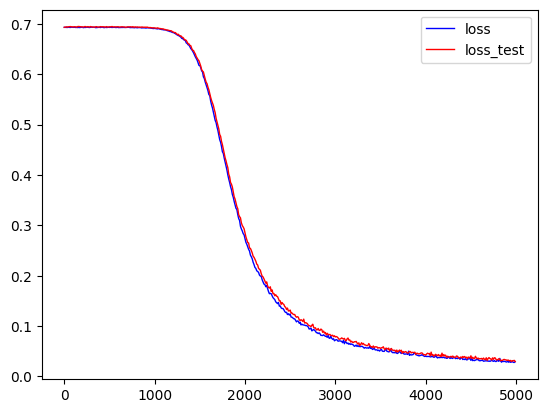

In [23]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

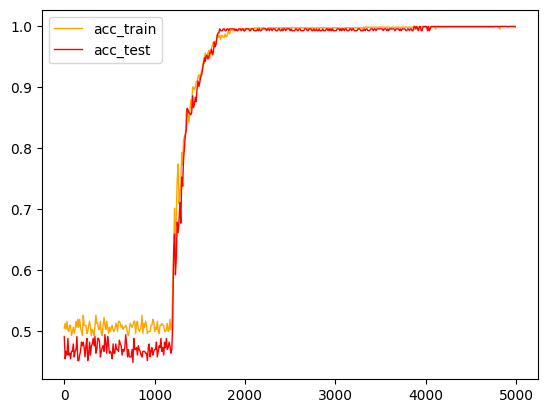

In [24]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()

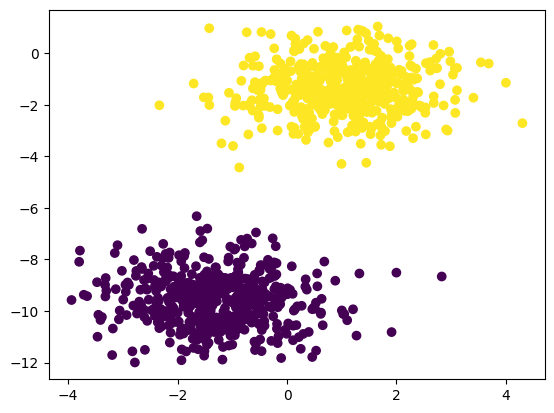

In [9]:
x, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=2, random_state=2)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE)

x_train_t = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test_t = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train_t = torch.from_numpy(y_train).type(torch.LongTensor)
y_test_t = torch.from_numpy(y_test).type(torch.LongTensor)

x_t = torch.from_numpy(x).type(torch.FloatTensor)
y_t = torch.from_numpy(y).type(torch.LongTensor)

train_dataset = TensorDataset(x_train_t, y_train_t)
test_dataset = TensorDataset(x_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

plt.scatter(x[:,0], x[:,1], c=y)

In [17]:
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
epoch_list = []

In [18]:
model = train(optimizer='SGD', learning_rate=0.01, max_epochs=1500, eval_freq=10, save_para=False)

start training MLP...
cuda:0


  0%|          | 1/1500 [00:00<14:04,  1.77it/s]

TRAIN epoch: 0, loss : 0.693153, ACC: 0.527902
TEST epoch: 0, loss : 0.693196, ACC: 0.483507


  1%|          | 11/1500 [00:03<09:30,  2.61it/s]

TRAIN epoch: 10, loss : 0.692503, ACC: 0.512277
TEST epoch: 10, loss : 0.692932, ACC: 0.468316


  1%|▏         | 21/1500 [00:07<09:13,  2.67it/s]

TRAIN epoch: 20, loss : 0.663864, ACC: 0.502232
TEST epoch: 20, loss : 0.660329, ACC: 0.474392


  2%|▏         | 31/1500 [00:10<09:14,  2.65it/s]

TRAIN epoch: 30, loss : 0.463649, ACC: 0.686384
TEST epoch: 30, loss : 0.470764, ACC: 0.683594


  3%|▎         | 41/1500 [00:13<09:10,  2.65it/s]

TRAIN epoch: 40, loss : 0.355519, ACC: 0.879464
TEST epoch: 40, loss : 0.365527, ACC: 0.887587


  3%|▎         | 51/1500 [00:16<09:14,  2.61it/s]

TRAIN epoch: 50, loss : 0.293206, ACC: 0.938616
TEST epoch: 50, loss : 0.297307, ACC: 0.951823


  4%|▍         | 61/1500 [00:19<09:01,  2.66it/s]

TRAIN epoch: 60, loss : 0.240156, ACC: 0.976563
TEST epoch: 60, loss : 0.253295, ACC: 0.960503


  5%|▍         | 71/1500 [00:23<09:00,  2.65it/s]

TRAIN epoch: 70, loss : 0.202551, ACC: 0.987723
TEST epoch: 70, loss : 0.211991, ACC: 0.992188


  5%|▌         | 81/1500 [00:26<09:05,  2.60it/s]

TRAIN epoch: 80, loss : 0.177373, ACC: 0.992188
TEST epoch: 80, loss : 0.182061, ACC: 0.992188


  6%|▌         | 91/1500 [00:29<08:47,  2.67it/s]

TRAIN epoch: 90, loss : 0.160573, ACC: 0.991071
TEST epoch: 90, loss : 0.159639, ACC: 0.996094


  7%|▋         | 101/1500 [00:32<08:47,  2.65it/s]

TRAIN epoch: 100, loss : 0.138917, ACC: 0.994420
TEST epoch: 100, loss : 0.143272, ACC: 0.993056


  7%|▋         | 111/1500 [00:35<08:43,  2.65it/s]

TRAIN epoch: 110, loss : 0.125849, ACC: 0.994420
TEST epoch: 110, loss : 0.126220, ACC: 1.000000


  8%|▊         | 121/1500 [00:39<08:40,  2.65it/s]

TRAIN epoch: 120, loss : 0.111891, ACC: 0.994420
TEST epoch: 120, loss : 0.115031, ACC: 1.000000


  9%|▊         | 131/1500 [00:42<08:39,  2.63it/s]

TRAIN epoch: 130, loss : 0.103729, ACC: 0.995536
TEST epoch: 130, loss : 0.107219, ACC: 1.000000


  9%|▉         | 141/1500 [00:45<08:37,  2.63it/s]

TRAIN epoch: 140, loss : 0.096679, ACC: 0.995536
TEST epoch: 140, loss : 0.097623, ACC: 1.000000


 10%|█         | 151/1500 [00:48<08:52,  2.53it/s]

TRAIN epoch: 150, loss : 0.088598, ACC: 0.995536
TEST epoch: 150, loss : 0.091171, ACC: 1.000000


 11%|█         | 161/1500 [00:52<08:36,  2.59it/s]

TRAIN epoch: 160, loss : 0.081031, ACC: 0.995536
TEST epoch: 160, loss : 0.080585, ACC: 1.000000


 11%|█▏        | 171/1500 [00:55<08:32,  2.59it/s]

TRAIN epoch: 170, loss : 0.076661, ACC: 0.995536
TEST epoch: 170, loss : 0.076902, ACC: 1.000000


 12%|█▏        | 181/1500 [00:58<08:27,  2.60it/s]

TRAIN epoch: 180, loss : 0.071851, ACC: 0.995536
TEST epoch: 180, loss : 0.074251, ACC: 1.000000


 13%|█▎        | 191/1500 [01:01<08:13,  2.65it/s]

TRAIN epoch: 190, loss : 0.067949, ACC: 0.995536
TEST epoch: 190, loss : 0.070687, ACC: 1.000000


 13%|█▎        | 201/1500 [01:05<08:11,  2.64it/s]

TRAIN epoch: 200, loss : 0.062991, ACC: 0.996652
TEST epoch: 200, loss : 0.064835, ACC: 1.000000


 14%|█▍        | 211/1500 [01:08<08:08,  2.64it/s]

TRAIN epoch: 210, loss : 0.061593, ACC: 0.996652
TEST epoch: 210, loss : 0.062710, ACC: 1.000000


 15%|█▍        | 221/1500 [01:11<08:02,  2.65it/s]

TRAIN epoch: 220, loss : 0.059275, ACC: 0.993304
TEST epoch: 220, loss : 0.059458, ACC: 1.000000


 15%|█▌        | 231/1500 [01:14<07:55,  2.67it/s]

TRAIN epoch: 230, loss : 0.054511, ACC: 0.996652
TEST epoch: 230, loss : 0.055759, ACC: 1.000000


 16%|█▌        | 241/1500 [01:18<07:59,  2.63it/s]

TRAIN epoch: 240, loss : 0.054501, ACC: 0.996652
TEST epoch: 240, loss : 0.052502, ACC: 1.000000


 17%|█▋        | 251/1500 [01:21<07:55,  2.63it/s]

TRAIN epoch: 250, loss : 0.051069, ACC: 0.996652
TEST epoch: 250, loss : 0.051250, ACC: 1.000000


 17%|█▋        | 261/1500 [01:24<07:50,  2.63it/s]

TRAIN epoch: 260, loss : 0.047531, ACC: 0.996652
TEST epoch: 260, loss : 0.048496, ACC: 1.000000


 18%|█▊        | 271/1500 [01:27<07:42,  2.66it/s]

TRAIN epoch: 270, loss : 0.044639, ACC: 0.997768
TEST epoch: 270, loss : 0.047199, ACC: 1.000000


 19%|█▊        | 281/1500 [01:30<07:42,  2.63it/s]

TRAIN epoch: 280, loss : 0.045232, ACC: 0.997768
TEST epoch: 280, loss : 0.043508, ACC: 1.000000


 19%|█▉        | 291/1500 [01:34<07:28,  2.70it/s]

TRAIN epoch: 290, loss : 0.043070, ACC: 0.997768
TEST epoch: 290, loss : 0.042650, ACC: 1.000000


 20%|██        | 301/1500 [01:37<07:32,  2.65it/s]

TRAIN epoch: 300, loss : 0.040946, ACC: 0.998884
TEST epoch: 300, loss : 0.043272, ACC: 1.000000


 21%|██        | 311/1500 [01:40<07:33,  2.62it/s]

TRAIN epoch: 310, loss : 0.038985, ACC: 0.998884
TEST epoch: 310, loss : 0.040014, ACC: 1.000000


 21%|██▏       | 321/1500 [01:43<07:22,  2.67it/s]

TRAIN epoch: 320, loss : 0.036999, ACC: 0.998884
TEST epoch: 320, loss : 0.039516, ACC: 1.000000


 22%|██▏       | 331/1500 [01:47<07:21,  2.65it/s]

TRAIN epoch: 330, loss : 0.036025, ACC: 0.998884
TEST epoch: 330, loss : 0.038677, ACC: 1.000000


 23%|██▎       | 341/1500 [01:50<07:34,  2.55it/s]

TRAIN epoch: 340, loss : 0.035730, ACC: 0.998884
TEST epoch: 340, loss : 0.035969, ACC: 1.000000


 23%|██▎       | 351/1500 [01:53<07:31,  2.55it/s]

TRAIN epoch: 350, loss : 0.036671, ACC: 0.998884
TEST epoch: 350, loss : 0.034367, ACC: 1.000000


 24%|██▍       | 361/1500 [01:56<07:11,  2.64it/s]

TRAIN epoch: 360, loss : 0.033453, ACC: 0.998884
TEST epoch: 360, loss : 0.032831, ACC: 1.000000


 25%|██▍       | 371/1500 [02:00<07:03,  2.67it/s]

TRAIN epoch: 370, loss : 0.032506, ACC: 0.998884
TEST epoch: 370, loss : 0.032729, ACC: 1.000000


 25%|██▌       | 381/1500 [02:03<07:09,  2.60it/s]

TRAIN epoch: 380, loss : 0.033134, ACC: 0.998884
TEST epoch: 380, loss : 0.031241, ACC: 1.000000


 26%|██▌       | 391/1500 [02:06<06:56,  2.66it/s]

TRAIN epoch: 390, loss : 0.030773, ACC: 0.998884
TEST epoch: 390, loss : 0.030559, ACC: 1.000000


 27%|██▋       | 401/1500 [02:09<06:56,  2.64it/s]

TRAIN epoch: 400, loss : 0.030071, ACC: 0.998884
TEST epoch: 400, loss : 0.029193, ACC: 1.000000


 27%|██▋       | 411/1500 [02:12<06:59,  2.60it/s]

TRAIN epoch: 410, loss : 0.029259, ACC: 0.998884
TEST epoch: 410, loss : 0.028182, ACC: 1.000000


 28%|██▊       | 421/1500 [02:16<06:51,  2.62it/s]

TRAIN epoch: 420, loss : 0.028679, ACC: 0.998884
TEST epoch: 420, loss : 0.030466, ACC: 1.000000


 29%|██▊       | 431/1500 [02:19<06:42,  2.65it/s]

TRAIN epoch: 430, loss : 0.027953, ACC: 0.998884
TEST epoch: 430, loss : 0.027721, ACC: 1.000000


 29%|██▉       | 441/1500 [02:22<06:38,  2.66it/s]

TRAIN epoch: 440, loss : 0.026569, ACC: 0.998884
TEST epoch: 440, loss : 0.026431, ACC: 1.000000


 30%|███       | 451/1500 [02:25<06:30,  2.68it/s]

TRAIN epoch: 450, loss : 0.026174, ACC: 0.998884
TEST epoch: 450, loss : 0.026442, ACC: 1.000000


 31%|███       | 461/1500 [02:29<06:33,  2.64it/s]

TRAIN epoch: 460, loss : 0.025798, ACC: 0.998884
TEST epoch: 460, loss : 0.025272, ACC: 1.000000


 31%|███▏      | 471/1500 [02:32<06:27,  2.66it/s]

TRAIN epoch: 470, loss : 0.025363, ACC: 0.998884
TEST epoch: 470, loss : 0.024926, ACC: 1.000000


 32%|███▏      | 481/1500 [02:35<06:27,  2.63it/s]

TRAIN epoch: 480, loss : 0.024677, ACC: 0.998884
TEST epoch: 480, loss : 0.024252, ACC: 1.000000


 33%|███▎      | 491/1500 [02:38<06:21,  2.64it/s]

TRAIN epoch: 490, loss : 0.024419, ACC: 0.998884
TEST epoch: 490, loss : 0.024141, ACC: 1.000000


 33%|███▎      | 501/1500 [02:41<06:17,  2.65it/s]

TRAIN epoch: 500, loss : 0.023407, ACC: 0.998884
TEST epoch: 500, loss : 0.024435, ACC: 1.000000


 34%|███▍      | 511/1500 [02:45<06:27,  2.55it/s]

TRAIN epoch: 510, loss : 0.024249, ACC: 0.998884
TEST epoch: 510, loss : 0.022729, ACC: 1.000000


 35%|███▍      | 521/1500 [02:48<06:09,  2.65it/s]

TRAIN epoch: 520, loss : 0.023171, ACC: 0.998884
TEST epoch: 520, loss : 0.022909, ACC: 1.000000


 35%|███▌      | 531/1500 [02:51<06:27,  2.50it/s]

TRAIN epoch: 530, loss : 0.021281, ACC: 0.998884
TEST epoch: 530, loss : 0.020987, ACC: 1.000000


 36%|███▌      | 541/1500 [02:55<05:58,  2.68it/s]

TRAIN epoch: 540, loss : 0.021187, ACC: 0.998884
TEST epoch: 540, loss : 0.022089, ACC: 1.000000


 37%|███▋      | 551/1500 [02:58<05:59,  2.64it/s]

TRAIN epoch: 550, loss : 0.020967, ACC: 0.998884
TEST epoch: 550, loss : 0.021050, ACC: 1.000000


 37%|███▋      | 561/1500 [03:01<05:49,  2.68it/s]

TRAIN epoch: 560, loss : 0.021014, ACC: 0.998884
TEST epoch: 560, loss : 0.021064, ACC: 1.000000


 38%|███▊      | 571/1500 [03:04<05:50,  2.65it/s]

TRAIN epoch: 570, loss : 0.020133, ACC: 0.998884
TEST epoch: 570, loss : 0.019859, ACC: 1.000000


 39%|███▊      | 581/1500 [03:07<05:47,  2.64it/s]

TRAIN epoch: 580, loss : 0.019911, ACC: 0.998884
TEST epoch: 580, loss : 0.019366, ACC: 1.000000


 39%|███▉      | 591/1500 [03:11<05:44,  2.64it/s]

TRAIN epoch: 590, loss : 0.019324, ACC: 0.998884
TEST epoch: 590, loss : 0.019998, ACC: 1.000000


 40%|████      | 601/1500 [03:14<05:36,  2.67it/s]

TRAIN epoch: 600, loss : 0.019232, ACC: 0.998884
TEST epoch: 600, loss : 0.018294, ACC: 1.000000


 41%|████      | 611/1500 [03:17<05:33,  2.66it/s]

TRAIN epoch: 610, loss : 0.021757, ACC: 0.995536
TEST epoch: 610, loss : 0.019348, ACC: 1.000000


 41%|████▏     | 621/1500 [03:20<05:39,  2.59it/s]

TRAIN epoch: 620, loss : 0.018609, ACC: 0.998884
TEST epoch: 620, loss : 0.018645, ACC: 1.000000


 42%|████▏     | 631/1500 [03:24<05:32,  2.61it/s]

TRAIN epoch: 630, loss : 0.018397, ACC: 0.998884
TEST epoch: 630, loss : 0.018344, ACC: 1.000000


 43%|████▎     | 641/1500 [03:27<05:25,  2.64it/s]

TRAIN epoch: 640, loss : 0.018799, ACC: 0.998884
TEST epoch: 640, loss : 0.017519, ACC: 1.000000


 43%|████▎     | 651/1500 [03:30<05:21,  2.64it/s]

TRAIN epoch: 650, loss : 0.017569, ACC: 0.998884
TEST epoch: 650, loss : 0.017532, ACC: 1.000000


 44%|████▍     | 661/1500 [03:33<05:18,  2.63it/s]

TRAIN epoch: 660, loss : 0.018020, ACC: 0.998884
TEST epoch: 660, loss : 0.018607, ACC: 1.000000


 45%|████▍     | 671/1500 [03:36<05:10,  2.67it/s]

TRAIN epoch: 670, loss : 0.017157, ACC: 0.998884
TEST epoch: 670, loss : 0.017616, ACC: 1.000000


 45%|████▌     | 681/1500 [03:40<05:18,  2.57it/s]

TRAIN epoch: 680, loss : 0.016765, ACC: 0.998884
TEST epoch: 680, loss : 0.016867, ACC: 1.000000


 46%|████▌     | 691/1500 [03:43<05:07,  2.63it/s]

TRAIN epoch: 690, loss : 0.016359, ACC: 0.998884
TEST epoch: 690, loss : 0.016358, ACC: 1.000000


 47%|████▋     | 701/1500 [03:46<05:07,  2.60it/s]

TRAIN epoch: 700, loss : 0.016417, ACC: 0.998884
TEST epoch: 700, loss : 0.016763, ACC: 1.000000


 47%|████▋     | 711/1500 [03:49<04:58,  2.64it/s]

TRAIN epoch: 710, loss : 0.016627, ACC: 0.998884
TEST epoch: 710, loss : 0.015293, ACC: 1.000000


 48%|████▊     | 721/1500 [03:53<05:15,  2.47it/s]

TRAIN epoch: 720, loss : 0.015990, ACC: 0.998884
TEST epoch: 720, loss : 0.015831, ACC: 1.000000


 49%|████▊     | 731/1500 [03:56<04:44,  2.70it/s]

TRAIN epoch: 730, loss : 0.015051, ACC: 0.998884
TEST epoch: 730, loss : 0.015186, ACC: 1.000000


 49%|████▉     | 741/1500 [03:59<04:54,  2.58it/s]

TRAIN epoch: 740, loss : 0.014976, ACC: 0.998884
TEST epoch: 740, loss : 0.015472, ACC: 1.000000


 50%|█████     | 751/1500 [04:03<04:51,  2.57it/s]

TRAIN epoch: 750, loss : 0.015018, ACC: 0.998884
TEST epoch: 750, loss : 0.015291, ACC: 1.000000


 51%|█████     | 761/1500 [04:06<04:40,  2.64it/s]

TRAIN epoch: 760, loss : 0.016432, ACC: 0.998884
TEST epoch: 760, loss : 0.014396, ACC: 1.000000


 51%|█████▏    | 771/1500 [04:09<04:40,  2.60it/s]

TRAIN epoch: 770, loss : 0.014347, ACC: 0.998884
TEST epoch: 770, loss : 0.015031, ACC: 1.000000


 52%|█████▏    | 781/1500 [04:12<04:28,  2.68it/s]

TRAIN epoch: 780, loss : 0.015573, ACC: 0.998884
TEST epoch: 780, loss : 0.013986, ACC: 1.000000


 53%|█████▎    | 791/1500 [04:16<04:27,  2.65it/s]

TRAIN epoch: 790, loss : 0.014145, ACC: 0.998884
TEST epoch: 790, loss : 0.014325, ACC: 1.000000


 53%|█████▎    | 801/1500 [04:19<04:26,  2.63it/s]

TRAIN epoch: 800, loss : 0.014060, ACC: 0.998884
TEST epoch: 800, loss : 0.013617, ACC: 1.000000


 54%|█████▍    | 811/1500 [04:22<04:22,  2.63it/s]

TRAIN epoch: 810, loss : 0.014323, ACC: 0.998884
TEST epoch: 810, loss : 0.014137, ACC: 1.000000


 55%|█████▍    | 821/1500 [04:25<04:22,  2.59it/s]

TRAIN epoch: 820, loss : 0.013432, ACC: 0.998884
TEST epoch: 820, loss : 0.013541, ACC: 1.000000


 55%|█████▌    | 831/1500 [04:29<04:16,  2.61it/s]

TRAIN epoch: 830, loss : 0.013561, ACC: 0.998884
TEST epoch: 830, loss : 0.013318, ACC: 1.000000


 56%|█████▌    | 841/1500 [04:32<04:10,  2.64it/s]

TRAIN epoch: 840, loss : 0.013606, ACC: 0.998884
TEST epoch: 840, loss : 0.013206, ACC: 1.000000


 57%|█████▋    | 851/1500 [04:35<04:01,  2.69it/s]

TRAIN epoch: 850, loss : 0.013127, ACC: 0.998884
TEST epoch: 850, loss : 0.013171, ACC: 1.000000


 57%|█████▋    | 861/1500 [04:38<04:00,  2.66it/s]

TRAIN epoch: 860, loss : 0.013028, ACC: 0.998884
TEST epoch: 860, loss : 0.012945, ACC: 1.000000


 58%|█████▊    | 871/1500 [04:41<03:59,  2.63it/s]

TRAIN epoch: 870, loss : 0.012859, ACC: 0.998884
TEST epoch: 870, loss : 0.013006, ACC: 1.000000


 59%|█████▊    | 881/1500 [04:45<03:53,  2.65it/s]

TRAIN epoch: 880, loss : 0.012783, ACC: 0.998884
TEST epoch: 880, loss : 0.012162, ACC: 1.000000


 59%|█████▉    | 891/1500 [04:48<03:49,  2.66it/s]

TRAIN epoch: 890, loss : 0.012328, ACC: 0.998884
TEST epoch: 890, loss : 0.012311, ACC: 1.000000


 60%|██████    | 901/1500 [04:51<04:00,  2.49it/s]

TRAIN epoch: 900, loss : 0.012322, ACC: 1.000000
TEST epoch: 900, loss : 0.012491, ACC: 1.000000


 61%|██████    | 911/1500 [04:54<03:44,  2.63it/s]

TRAIN epoch: 910, loss : 0.013352, ACC: 1.000000
TEST epoch: 910, loss : 0.012326, ACC: 1.000000


 61%|██████▏   | 921/1500 [04:58<03:41,  2.61it/s]

TRAIN epoch: 920, loss : 0.012002, ACC: 1.000000
TEST epoch: 920, loss : 0.011853, ACC: 1.000000


 62%|██████▏   | 931/1500 [05:01<03:35,  2.64it/s]

TRAIN epoch: 930, loss : 0.011886, ACC: 1.000000
TEST epoch: 930, loss : 0.012089, ACC: 1.000000


 63%|██████▎   | 941/1500 [05:04<03:33,  2.62it/s]

TRAIN epoch: 940, loss : 0.011573, ACC: 1.000000
TEST epoch: 940, loss : 0.011996, ACC: 1.000000


 63%|██████▎   | 951/1500 [05:07<03:29,  2.62it/s]

TRAIN epoch: 950, loss : 0.011537, ACC: 1.000000
TEST epoch: 950, loss : 0.011419, ACC: 1.000000


 64%|██████▍   | 961/1500 [05:10<03:27,  2.60it/s]

TRAIN epoch: 960, loss : 0.011462, ACC: 1.000000
TEST epoch: 960, loss : 0.012042, ACC: 1.000000


 65%|██████▍   | 971/1500 [05:14<03:21,  2.62it/s]

TRAIN epoch: 970, loss : 0.011634, ACC: 1.000000
TEST epoch: 970, loss : 0.011269, ACC: 1.000000


 65%|██████▌   | 981/1500 [05:17<03:18,  2.62it/s]

TRAIN epoch: 980, loss : 0.011593, ACC: 1.000000
TEST epoch: 980, loss : 0.011246, ACC: 1.000000


 66%|██████▌   | 991/1500 [05:20<03:11,  2.66it/s]

TRAIN epoch: 990, loss : 0.010899, ACC: 1.000000
TEST epoch: 990, loss : 0.010587, ACC: 1.000000


 67%|██████▋   | 1001/1500 [05:23<03:09,  2.63it/s]

TRAIN epoch: 1000, loss : 0.010955, ACC: 1.000000
TEST epoch: 1000, loss : 0.011127, ACC: 1.000000


 67%|██████▋   | 1011/1500 [05:27<03:03,  2.67it/s]

TRAIN epoch: 1010, loss : 0.010793, ACC: 1.000000
TEST epoch: 1010, loss : 0.011028, ACC: 1.000000


 68%|██████▊   | 1021/1500 [05:30<03:01,  2.64it/s]

TRAIN epoch: 1020, loss : 0.011476, ACC: 1.000000
TEST epoch: 1020, loss : 0.010419, ACC: 1.000000


 69%|██████▊   | 1031/1500 [05:33<03:01,  2.58it/s]

TRAIN epoch: 1030, loss : 0.010665, ACC: 1.000000
TEST epoch: 1030, loss : 0.010758, ACC: 1.000000


 69%|██████▉   | 1041/1500 [05:36<02:56,  2.60it/s]

TRAIN epoch: 1040, loss : 0.010536, ACC: 1.000000
TEST epoch: 1040, loss : 0.010244, ACC: 1.000000


 70%|███████   | 1051/1500 [05:40<02:50,  2.63it/s]

TRAIN epoch: 1050, loss : 0.010631, ACC: 1.000000
TEST epoch: 1050, loss : 0.010004, ACC: 1.000000


 71%|███████   | 1061/1500 [05:43<02:47,  2.63it/s]

TRAIN epoch: 1060, loss : 0.010718, ACC: 1.000000
TEST epoch: 1060, loss : 0.010344, ACC: 1.000000


 71%|███████▏  | 1071/1500 [05:46<02:44,  2.61it/s]

TRAIN epoch: 1070, loss : 0.010166, ACC: 1.000000
TEST epoch: 1070, loss : 0.010133, ACC: 1.000000


 72%|███████▏  | 1081/1500 [05:49<02:37,  2.67it/s]

TRAIN epoch: 1080, loss : 0.010508, ACC: 1.000000
TEST epoch: 1080, loss : 0.010257, ACC: 1.000000


 73%|███████▎  | 1091/1500 [05:53<02:37,  2.60it/s]

TRAIN epoch: 1090, loss : 0.010297, ACC: 1.000000
TEST epoch: 1090, loss : 0.010161, ACC: 1.000000


 73%|███████▎  | 1101/1500 [05:56<02:31,  2.63it/s]

TRAIN epoch: 1100, loss : 0.010866, ACC: 1.000000
TEST epoch: 1100, loss : 0.010284, ACC: 1.000000


 74%|███████▍  | 1111/1500 [05:59<02:28,  2.63it/s]

TRAIN epoch: 1110, loss : 0.009898, ACC: 1.000000
TEST epoch: 1110, loss : 0.010087, ACC: 1.000000


 75%|███████▍  | 1121/1500 [06:02<02:24,  2.63it/s]

TRAIN epoch: 1120, loss : 0.009566, ACC: 1.000000
TEST epoch: 1120, loss : 0.009705, ACC: 1.000000


 75%|███████▌  | 1131/1500 [06:06<02:20,  2.62it/s]

TRAIN epoch: 1130, loss : 0.009727, ACC: 1.000000
TEST epoch: 1130, loss : 0.009540, ACC: 1.000000


 76%|███████▌  | 1141/1500 [06:09<02:15,  2.65it/s]

TRAIN epoch: 1140, loss : 0.010303, ACC: 1.000000
TEST epoch: 1140, loss : 0.009606, ACC: 1.000000


 77%|███████▋  | 1151/1500 [06:12<02:08,  2.71it/s]

TRAIN epoch: 1150, loss : 0.009631, ACC: 1.000000
TEST epoch: 1150, loss : 0.009535, ACC: 1.000000


 77%|███████▋  | 1161/1500 [06:15<02:08,  2.63it/s]

TRAIN epoch: 1160, loss : 0.009149, ACC: 1.000000
TEST epoch: 1160, loss : 0.009882, ACC: 1.000000


 78%|███████▊  | 1171/1500 [06:19<02:08,  2.57it/s]

TRAIN epoch: 1170, loss : 0.009241, ACC: 1.000000
TEST epoch: 1170, loss : 0.009113, ACC: 1.000000


 79%|███████▊  | 1181/1500 [06:22<01:59,  2.66it/s]

TRAIN epoch: 1180, loss : 0.009692, ACC: 1.000000
TEST epoch: 1180, loss : 0.009694, ACC: 1.000000


 79%|███████▉  | 1191/1500 [06:25<01:57,  2.63it/s]

TRAIN epoch: 1190, loss : 0.009096, ACC: 1.000000
TEST epoch: 1190, loss : 0.009139, ACC: 1.000000


 80%|████████  | 1201/1500 [06:28<01:51,  2.68it/s]

TRAIN epoch: 1200, loss : 0.009539, ACC: 1.000000
TEST epoch: 1200, loss : 0.008607, ACC: 1.000000


 81%|████████  | 1211/1500 [06:31<01:48,  2.68it/s]

TRAIN epoch: 1210, loss : 0.008609, ACC: 1.000000
TEST epoch: 1210, loss : 0.009075, ACC: 1.000000


 81%|████████▏ | 1221/1500 [06:35<01:46,  2.61it/s]

TRAIN epoch: 1220, loss : 0.008765, ACC: 1.000000
TEST epoch: 1220, loss : 0.008979, ACC: 1.000000


 82%|████████▏ | 1231/1500 [06:38<01:41,  2.65it/s]

TRAIN epoch: 1230, loss : 0.008737, ACC: 1.000000
TEST epoch: 1230, loss : 0.008745, ACC: 1.000000


 83%|████████▎ | 1241/1500 [06:41<01:37,  2.65it/s]

TRAIN epoch: 1240, loss : 0.008560, ACC: 1.000000
TEST epoch: 1240, loss : 0.009035, ACC: 1.000000


 83%|████████▎ | 1251/1500 [06:44<01:36,  2.57it/s]

TRAIN epoch: 1250, loss : 0.008530, ACC: 1.000000
TEST epoch: 1250, loss : 0.008437, ACC: 1.000000


 84%|████████▍ | 1261/1500 [06:48<01:30,  2.63it/s]

TRAIN epoch: 1260, loss : 0.008446, ACC: 1.000000
TEST epoch: 1260, loss : 0.008402, ACC: 1.000000


 85%|████████▍ | 1271/1500 [06:51<01:31,  2.51it/s]

TRAIN epoch: 1270, loss : 0.008531, ACC: 1.000000
TEST epoch: 1270, loss : 0.008718, ACC: 1.000000


 85%|████████▌ | 1281/1500 [06:54<01:26,  2.54it/s]

TRAIN epoch: 1280, loss : 0.008538, ACC: 1.000000
TEST epoch: 1280, loss : 0.008248, ACC: 1.000000


 86%|████████▌ | 1291/1500 [06:58<01:20,  2.58it/s]

TRAIN epoch: 1290, loss : 0.008386, ACC: 1.000000
TEST epoch: 1290, loss : 0.008752, ACC: 1.000000


 87%|████████▋ | 1301/1500 [07:01<01:16,  2.60it/s]

TRAIN epoch: 1300, loss : 0.008362, ACC: 1.000000
TEST epoch: 1300, loss : 0.008815, ACC: 1.000000


 87%|████████▋ | 1311/1500 [07:04<01:12,  2.62it/s]

TRAIN epoch: 1310, loss : 0.008186, ACC: 1.000000
TEST epoch: 1310, loss : 0.008144, ACC: 1.000000


 88%|████████▊ | 1321/1500 [07:07<01:08,  2.62it/s]

TRAIN epoch: 1320, loss : 0.008218, ACC: 1.000000
TEST epoch: 1320, loss : 0.008233, ACC: 1.000000


 89%|████████▊ | 1331/1500 [07:11<01:04,  2.61it/s]

TRAIN epoch: 1330, loss : 0.009790, ACC: 1.000000
TEST epoch: 1330, loss : 0.008380, ACC: 1.000000


 89%|████████▉ | 1341/1500 [07:14<00:59,  2.66it/s]

TRAIN epoch: 1340, loss : 0.008244, ACC: 1.000000
TEST epoch: 1340, loss : 0.008043, ACC: 1.000000


 90%|█████████ | 1351/1500 [07:17<00:55,  2.69it/s]

TRAIN epoch: 1350, loss : 0.009977, ACC: 1.000000
TEST epoch: 1350, loss : 0.007609, ACC: 1.000000


 91%|█████████ | 1361/1500 [07:20<00:51,  2.68it/s]

TRAIN epoch: 1360, loss : 0.008060, ACC: 1.000000
TEST epoch: 1360, loss : 0.007877, ACC: 1.000000


 91%|█████████▏| 1371/1500 [07:24<00:48,  2.64it/s]

TRAIN epoch: 1370, loss : 0.008669, ACC: 1.000000
TEST epoch: 1370, loss : 0.008040, ACC: 1.000000


 92%|█████████▏| 1381/1500 [07:27<00:45,  2.62it/s]

TRAIN epoch: 1380, loss : 0.007786, ACC: 1.000000
TEST epoch: 1380, loss : 0.007861, ACC: 1.000000


 93%|█████████▎| 1391/1500 [07:30<00:41,  2.66it/s]

TRAIN epoch: 1390, loss : 0.007810, ACC: 1.000000
TEST epoch: 1390, loss : 0.007645, ACC: 1.000000


 93%|█████████▎| 1401/1500 [07:33<00:37,  2.62it/s]

TRAIN epoch: 1400, loss : 0.007503, ACC: 1.000000
TEST epoch: 1400, loss : 0.007579, ACC: 1.000000


 94%|█████████▍| 1411/1500 [07:36<00:33,  2.68it/s]

TRAIN epoch: 1410, loss : 0.007517, ACC: 1.000000
TEST epoch: 1410, loss : 0.007424, ACC: 1.000000


 95%|█████████▍| 1421/1500 [07:40<00:29,  2.68it/s]

TRAIN epoch: 1420, loss : 0.007505, ACC: 1.000000
TEST epoch: 1420, loss : 0.007245, ACC: 1.000000


 95%|█████████▌| 1431/1500 [07:43<00:26,  2.64it/s]

TRAIN epoch: 1430, loss : 0.007689, ACC: 1.000000
TEST epoch: 1430, loss : 0.006957, ACC: 1.000000


 96%|█████████▌| 1441/1500 [07:46<00:22,  2.65it/s]

TRAIN epoch: 1440, loss : 0.007428, ACC: 1.000000
TEST epoch: 1440, loss : 0.007254, ACC: 1.000000


 97%|█████████▋| 1451/1500 [07:49<00:18,  2.67it/s]

TRAIN epoch: 1450, loss : 0.007678, ACC: 1.000000
TEST epoch: 1450, loss : 0.007601, ACC: 1.000000


 97%|█████████▋| 1461/1500 [07:53<00:14,  2.62it/s]

TRAIN epoch: 1460, loss : 0.007487, ACC: 1.000000
TEST epoch: 1460, loss : 0.007373, ACC: 1.000000


 98%|█████████▊| 1471/1500 [07:56<00:10,  2.65it/s]

TRAIN epoch: 1470, loss : 0.007050, ACC: 1.000000
TEST epoch: 1470, loss : 0.006941, ACC: 1.000000


 99%|█████████▊| 1481/1500 [07:59<00:07,  2.67it/s]

TRAIN epoch: 1480, loss : 0.007041, ACC: 1.000000
TEST epoch: 1480, loss : 0.006781, ACC: 1.000000


 99%|█████████▉| 1491/1500 [08:02<00:03,  2.63it/s]

TRAIN epoch: 1490, loss : 0.007184, ACC: 1.000000
TEST epoch: 1490, loss : 0.007311, ACC: 1.000000


100%|██████████| 1500/1500 [08:05<00:00,  3.09it/s]


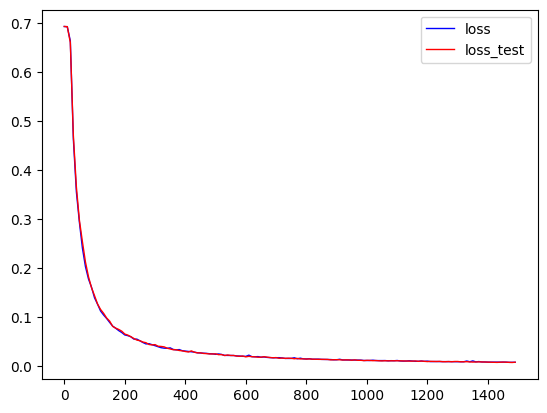

In [19]:
plt.plot(epoch_list, loss_train_list, linewidth=1, color="blue",label="loss")
plt.plot(epoch_list, loss_test_list, linewidth=1, color="red",label="loss_test")
plt.legend()

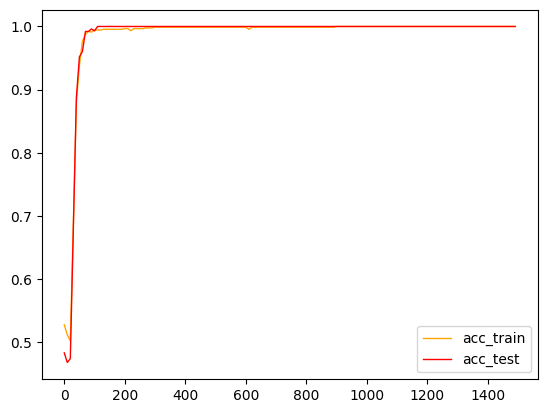

In [20]:
plt.plot(epoch_list, acc_train_list, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_list, acc_test_list, linewidth=1, color="red",label="acc_test")
plt.legend()